In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '../'))
sys.path.append(parent_dir)
from em_utils import * # import the utils

In [ ]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/merf_dfs/"
os.makedirs(df_dir, exist_ok=True)

print("---------- Read data ----------")
input_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/april_processing/"
delta = read_data(input_dir, "all_delta_april29.csv")
print(delta.columns.to_list())

In [ ]:
#Make time numeric 
time_mapping = {
    "BL": 0,
    "6m": 6,
    "12m": 12
}
delta['time'] = delta['time'].replace(time_mapping)
print(delta['time'])

In [15]:
# Make omic subsets
BMI_VAR, ID_VAR, TIME_VAR, DATA = 'outcome_BMI_fnl', 'subject_id', 'time', delta
# Define the column names based on your lists
basic = [BMI_VAR, ID_VAR, TIME_VAR, 'sex', 'age']
meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'sex', 'race', 
             'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
only_taxa = [BMI_VAR, ID_VAR, TIME_VAR,] + [col for col in DATA.columns if col.startswith("g__")]

micom_start = DATA.columns.get_loc("Diacetyl")
micom_end = DATA.columns.get_loc("aldehydo.D.xylose")
only_micom = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[micom_start:micom_end + 1])

path_start = DATA.columns.get_loc("arginine..ornithine.and.proline.interconversion")
path_end = DATA.columns.get_loc("UDP.N.acetyl.D.glucosamine.biosynthesis.I")
only_pathway = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[path_start:path_end + 1])

metabo_start = DATA.columns.get_loc("non_HDL_C")
metabo_end = DATA.columns.get_loc("IDL_TG_pct")
only_metabo = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[metabo_start:metabo_end + 1])

all_col = [BMI_VAR, ID_VAR, TIME_VAR,] + ['randomized_group', 'sex', 'race',
    'age','Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid'] + \
    list(DATA.columns[DATA.columns.str.startswith("g__")]) + \
    list(DATA.columns[micom_start:micom_end + 1]) + \
    list(DATA.columns[path_start:path_end + 1]) + \
    list(DATA.columns[metabo_start:metabo_end + 1])

In [ ]:
# Make train and test sets 
# test sample names
test_names = ["ABR-079", "AGA-071", "AHE-055", "ALI-121", "ALO-163", "AMA-031", "ASO-013", "AWI-167", "BMO-164", "CWA-183", "DSC-024", "EBE-130", "EHI-177", "EJO-092", "GFU-188", "HGI-010", "JCA-109", "JGO-100",
    "KBU-085", "KCE-034", "KHE-170", "LDO-148", "LST-186", "LZD-142", "MAR-119", "MCA-088", "MJA-153", "MWE-112", "NPO-149", "RAE-114", "SBO-020", "SEG-080", "SKA-195", "SLO-178", "SSH-028", "TDU-086","TFA-016", "VCA-041"]
# train sample names
train_names = ["AAL-144", "ACO-053", "ADA-105", "AKE-009", "AKI-011", "AKO-139", "AMC-155", "AME-128", "AME-157", "ATA-129", "AWA-052", "AWA-083", "BAN-193", "BHO-014", "BIN-201", "BKN-104", "BMI-156", "BSA-174", "CAM-057", "CCO-189",
    "CED-026", "CEL-073", "CGA-134", "CIS-077", "CKR-078", "CLE-049", "COW-066", "CRO-108", "CWA-161", "EBE-051", "EKA-135", "EKR-045", "ELA-159", "EPO-182", "EVO-184", "FWI-098", "GHA-035", "HDE-154", "IBE-120", "JDI-140", "JER-110", "JFU-027", "JJO-093", "JKN-127", "JPO-022", "JUG-116", "JUT-032", "JVE-126", "KAN-138", "KBR-162", "KEL-185", "KEL-199", "KGI-029", "KHU-196", "KPA-042", "KRI-072", "KVA-038", "KWA-122", "KWA-141", "LBL-047", "LBU-015", "LEL-147", "LFI-003", "LJA-101", "LMC-111", "LPF-198", "LVA-017", "MBA-187", "MCW-065", "MDI-107", "MES-068", "MFB-118", "MGA-076", "MHO-117", "MKE-192", "MMA-036", "MRT-179", "MSH-091", "MST-039", "MWE-143",
    "MWO-133", "MWY-152", "NAR-099", "NBI-048", "NBI-069", "NCO-171", "NDI-067", "NEL-094", "NKA-090", "NMO-151", "NTA-021", "PBE-123", "QNG-166", "RAF-125", "RAM-050", "RHP-023", "RLA-132", "ROL-006", "SAB-160", "SCA-043", "SCR-061", "SDA-150", "SGA-062", "SKA-087", "SRO-194", "TBU-115", "TFA-172", "TRO-113", "TSH-146", "TSL-056", "WPE-005", "YOR-103", "YSU-097", "ZVU-096"]
print("Length of test names:", len(test_names))
print("Length of train names:", len(train_names))

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -17.691620278822846 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -13.102908846821231 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs

Subset for meta_keep created with shape: (196, 13)
---------- Select predictors for training set ----------
Length of X: 140, Length of clusters_train: 140, Length of Y: 140
Final columns after drop: ['time', 'randomized_group', 'sex', 'race', 'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
X train values: 0     -2.712038
1     -1.718260
4     -2.129361
5     -3.741923
8     -1.241902
         ...   
190   -0.076833
191   -0.763860
192   -0.332028
194    1.012722
195   -0.702777
Name: outcome_BMI_fnl, Length: 140, dtype: float64
---------- Select predictors for test set ----------
Combination: (10, None, 0.05, 2, 3)

Progress: 1.85% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.1512, prev: 0.8488, OOB Score: 17.4000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 28.28899121190436 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 25.236290873347652 at iteration 1.
INFO     [merf.py:307] Training GLL is 35.66434323825859 at iteration 2.
INFO     [merf.py:307] Training GLL is 36.04963031536786 at iteration 1.
INFO     [merf.py:307] Training GLL is 29.744147363279296 at iteration 2.


Combination, ptev: 0.1951, prev: 0.8049, OOB Score: 51.0000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.0547, prev: 0.9453, OOB Score: 31.3000
Combination: (10, None, 0.05, 2, 5)

Progress: 3.70% completed

Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.0786, prev: 0.9214, OOB Score: 29.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -15.133945890365741 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -31.198656797708757 at iteration 2.
INFO     [merf.py:307] Training GLL is 18.249684691219407 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 30.23040692413616 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omi

Combination, ptev: 0.1108, prev: 0.8892, OOB Score: 54.3000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1754, prev: 0.8246, OOB Score: 34.3000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.0950, prev: 0.9050, OOB Score: 30.1000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -7.554426150281182 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 32.65218664820351 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.0293, prev: 1.0293, OOB Score: 43.2000
Combination: (10, None, 0.05, 2, 10)

Progress: 5.56% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2465, prev: 0.7535, OOB Score: 26.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2353, prev: 0.7647, OOB Score: 44.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 15.238357648014016 at iteration 1.
INFO     [merf.py:307] Training GLL is 8.545783343915074 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 14.908284799911254 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.2735, prev: 0.7265, OOB Score: 42.2000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2354, prev: 0.7646, OOB Score: 55.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 53.493481261972846 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 32.7785617223947 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 31.066930359376133 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.1276, prev: 0.8724, OOB Score: 38.7000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1318, prev: 0.8682, OOB Score: 45.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 46.41777239698268 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.81524737021847 at iteration 2.


Combination, ptev: 0.1310, prev: 0.8690, OOB Score: 42.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0486, prev: 0.9514, OOB Score: 41.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 48.471856976298234 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 49.31864793808472 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 66.86924022691609 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.0446, prev: 0.9554, OOB Score: 38.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: -0.0205, prev: 1.0205, OOB Score: 36.3000
Combination: (10, None, 0.05, 10, 3)

Progress: 7.41% completed

Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -39.914632656751074 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -38.409198953986184 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs

Combination, ptev: 0.1298, prev: 0.8702, OOB Score: 25.8000
Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 4.83182600205533 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 2.567727794704003 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.1692, prev: 0.8308, OOB Score: 38.5000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 53.5100042902611 at iteration 5.
INFO     [merf.py:307] Training GLL is 58.00838667117485 at iteration 6.
INFO     [merf.py:307] Training GLL is 46.41135171149318 at iteration 7.
INFO     [merf.py:307] Training GLL is 47.98776368902406 at iteration 8.
INFO     [merf.py:307] Training GLL is 46.942989893826265 at iteration 9.
INFO     [merf.py:307] Training GLL is 50.836127233794514 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -13.863453292377267 at iteration 1.
INFO     [merf.py:307] Training GLL is 5.6216103742887 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.mode

Combination, ptev: -0.0390, prev: 1.0390, OOB Score: 39.1000
Combination: (10, None, 0.05, 10, 5)

Progress: 9.26% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 24.58629446605038 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 5.525962211530779 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 24.74034912800206 at iteration 7.
INFO     [merf.py:307] Training GLL is 12.56426259415743 at iteration 8.
INFO     [merf.py:307] Training GLL is 16.238555683959166 at ite

Combination, ptev: 0.2053, prev: 0.7947, OOB Score: 29.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -73.09535077577537 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -75.54875972101685 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -82.80311351129883 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: 0.1030, prev: 0.8970, OOB Score: 46.6000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 30.852410176569595 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 36.85420755576218 at iteration 5.
INFO     [merf.py:307] Training GLL is 32.28233346209904 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.1925, prev: 0.8075, OOB Score: 48.3000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 39.688084460499674 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 44.32448794941735 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.0681, prev: 0.9319, OOB Score: 36.6000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 42.14773140365614 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 35.448828632032516 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: -0.1197, prev: 1.1197, OOB Score: 52.3000
Combination: (10, None, 0.05, 10, 10)

Progress: 11.11% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 23.778093974091508 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 45.54380774700225 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1652, prev: 0.8348, OOB Score: 45.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.857024793481905 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 57.46753004108055 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.2583, prev: 0.7417, OOB Score: 29.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.97146671368011 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 7.816801394972384 at iteration 6.
INFO     [merf.py:307] Training GLL is 26.567778220152128 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.2862, prev: 0.7138, OOB Score: 29.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -29.49622650606234 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -20.71568928383204 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.2360, prev: 0.7640, OOB Score: 32.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 46.45461691815453 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 48.889060181755454 at iteration 7.
INFO     [merf.py:307] Training GLL is 21.254987796317074 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.1641, prev: 0.8359, OOB Score: 40.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 52.16793667412635 at iteration 6.
INFO     [merf.py:307] Training GLL is 48.323792708879886 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 28.575064563970393 at iteration 8.
INFO     [merf.py:307] Training GLL is 36.14258385267735 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.1782, prev: 0.8218, OOB Score: 45.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 25.46236430419396 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.803524050808555 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1609, prev: 0.8391, OOB Score: 36.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 47.028165276487314 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 47.171319640719446 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.1225, prev: 0.8775, OOB Score: 42.3000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 52.656595956305566 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 56.48584897247252 at iteration 7.
INFO     [merf.py:307] Training GLL is 21.691497499863452 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.74264769915582 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.0814, prev: 0.9186, OOB Score: 40.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 22.245891267612112 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 58.218953353229345 at iteration 6.
INFO     [merf.py:307] Training GLL is 45.69200058507405 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 52.05230918885627 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.0466, prev: 0.9534, OOB Score: 53.0000
Combination: (10, None, 0.1, 2, 3)

Progress: 12.96% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2505, prev: 0.7495, OOB Score: 40.3000
Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2823, prev: 0.7177, OOB Score: 63.4000
Length of clusters_train: 94
Length of clusters_test: 46


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.02505023132957 at iteration 1.
INFO     [merf.py:307] Training GLL is 80.54896140047897 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 81.91910255037989 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.0798, prev: 0.9202, OOB Score: 48.9000
Combination: (10, None, 0.1, 2, 5)

Progress: 14.81% completed

Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1864, prev: 0.8136, OOB Score: 47.2000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2019, prev: 0.7981, OOB Score: 48.4000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 92.24762586690228 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.56222666714928 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 102.02490140755741 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.2670, prev: 0.7330, OOB Score: 50.8000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1913, prev: 0.8087, OOB Score: 40.5000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.0550, prev: 0.9450, OOB Score: 53.0000
Combination: (10, None, 0.1, 2, 10)

Progress: 16.67% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 95.676748476696 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 110.95655699128325 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 98.58217377386966 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.3005, prev: 0.6995, OOB Score: 54.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3425, prev: 0.6575, OOB Score: 44.2000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3404, prev: 0.6596, OOB Score: 41.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 53.20996603942976 at iteration 1.
INFO     [merf.py:307] Training GLL is 37.236425266985904 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 96.3383292477691 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.2647, prev: 0.7353, OOB Score: 58.7000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1620, prev: 0.8380, OOB Score: 48.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2030, prev: 0.7970, OOB Score: 50.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 87.45962009879123 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 106.51327987065656 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1888, prev: 0.8112, OOB Score: 45.0000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0819, prev: 0.9181, OOB Score: 43.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0718, prev: 0.9282, OOB Score: 50.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 93.15067957384386 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.52223384476764 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.0266, prev: 0.9734, OOB Score: 45.7000
Combination: (10, None, 0.1, 10, 3)

Progress: 18.52% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 14.979044579355964 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 3.9387292879035147 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -21.407831154703338 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.1

Combination, ptev: 0.2361, prev: 0.7639, OOB Score: 39.8000
Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 52.12889063601066 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 59.40995672692875 at iteration 7.
INFO     [merf.py:307] Training GLL is 62.094412021955776 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.3403, prev: 0.6597, OOB Score: 57.8000
Length of clusters_train: 94
Length of clusters_test: 46


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.38338685743416 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 104.3011840941446 at iteration 6.
INFO     [merf.py:307] Training GLL is 95.7836599586453 at iteration 7.
INFO     [merf.py:307] Training GLL is 94.66667410161658 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: 0.0733, prev: 0.9267, OOB Score: 41.7000
Combination: (10, None, 0.1, 10, 5)

Progress: 20.37% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 82.06802690410142 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 67.73768353732224 at iteration 6.
INFO     [merf.py:307] Training GLL is 50.29938020394199 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 59.64010567474797 at iteration 8.
INFO     [merf.py:307] Training GLL is 60.95824723136549 at iter

Combination, ptev: 0.1166, prev: 0.8834, OOB Score: 37.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -1.2501473701089945 at iteration 6.
INFO     [merf.py:307] Training GLL is -6.689138005174047 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 0.6168563211429197 at iteration 8.
INFO     [merf.py:307] Training GLL is -0.2502386238728813 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 3.857263701653839 a

Combination, ptev: 0.1684, prev: 0.8316, OOB Score: 56.8000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 69.38643864086977 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 93.10751694271669 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.2355, prev: 0.7645, OOB Score: 51.4000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 101.81745345172355 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 103.63634790158707 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.1566, prev: 0.8434, OOB Score: 49.3000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 94.01908710120391 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 102.78992522403455 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.0179, prev: 0.9821, OOB Score: 59.3000
Combination: (10, None, 0.1, 10, 10)

Progress: 22.22% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 110.36713998207385 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 93.06127594642153 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.2137, prev: 0.7863, OOB Score: 45.7000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 90.14180574194955 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 67.65738821111174 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.2889, prev: 0.7111, OOB Score: 34.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 74.75736200767776 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 81.03540837276272 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.3336, prev: 0.6664, OOB Score: 40.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 54.550863497637714 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.37451520192322 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 23.075357154507348 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.2813, prev: 0.7187, OOB Score: 48.9000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 104.68922310416714 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 96.39166564940169 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1586, prev: 0.8414, OOB Score: 46.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 89.99243914270939 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 86.5654356452508 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.1798, prev: 0.8202, OOB Score: 47.5000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 93.16107355333673 at iteration 5.
INFO     [merf.py:307] Training GLL is 104.08312843179183 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.72019023046222 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.1688, prev: 0.8312, OOB Score: 39.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.20437109133134 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.71875849908909 at iteration 7.
INFO     [merf.py:307] Training GLL is 127.549422315153 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.28490035922671 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.0727, prev: 0.9273, OOB Score: 34.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 107.73184003228161 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.29551802033633 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.93681613549504 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.25938363434672 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: 0.0387, prev: 0.9613, OOB Score: 38.8000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 105.4266206788376 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 100.9303268308765 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.0037, prev: 0.9963, OOB Score: 53.0000
Combination: (10, None, 0.15, 2, 3)

Progress: 24.07% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2384, prev: 0.7616, OOB Score: 44.1000
Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2883, prev: 0.7117, OOB Score: 62.4000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 107.23992807634147 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 120.92654516340112 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 120.85328531832857 at iteration 1.
INFO     [merf.py:307] Training GLL is 105.78577514308753 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: 0.1289, prev: 0.8711, OOB Score: 42.5000
Combination: (10, None, 0.15, 2, 5)

Progress: 25.93% completed

Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1959, prev: 0.8041, OOB Score: 40.3000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2083, prev: 0.7917, OOB Score: 53.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 117.38840771939694 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 115.67211528670572 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 107.55039971975827 at iteration 1.
INFO     [merf.py:307] Training GLL is 137.4279079135712 at iteration 2.
INFO     [merf.py:307] Training GLL is 132.84286006709124 at 

Combination, ptev: 0.2588, prev: 0.7412, OOB Score: 58.1000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1514, prev: 0.8486, OOB Score: 51.5000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.0415, prev: 0.9585, OOB Score: 51.6000
Combination: (10, None, 0.15, 2, 10)

Progress: 27.78% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 139.64741498888108 at iteration 1.
INFO     [merf.py:307] Training GLL is 140.3111253132749 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 125.36659460167502 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.2405, prev: 0.7595, OOB Score: 54.7000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2927, prev: 0.7073, OOB Score: 46.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2869, prev: 0.7131, OOB Score: 47.7000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 90.98811207149055 at iteration 1.
INFO     [merf.py:307] Training GLL is 90.88546511865795 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.30803808122592 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

Combination, ptev: 0.2487, prev: 0.7513, OOB Score: 55.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1892, prev: 0.8108, OOB Score: 53.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2046, prev: 0.7954, OOB Score: 55.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 133.57967747225408 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 144.17927967477024 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 149.1150816427061 at iteration 1.
INFO     [merf.py:307] Training GLL is 150.89535069023302 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

Combination, ptev: 0.1969, prev: 0.8031, OOB Score: 50.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0842, prev: 0.9158, OOB Score: 54.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0656, prev: 0.9344, OOB Score: 51.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 120.26725827343544 at iteration 1.
INFO     [merf.py:307] Training GLL is 139.2547550122913 at iteration 2.
INFO     [merf.py:307] Training GLL is 41.90288945616593 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 34.89459529791412 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.0098, prev: 0.9902, OOB Score: 49.9000
Combination: (10, None, 0.15, 10, 3)

Progress: 29.63% completed

Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 25.514422198545656 at iteration 6.
INFO     [merf.py:307] Training GLL is 14.19074097728279 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 15.241313046061098 at iteration 8.
INFO     [merf.py:307] Training GLL is 11.202226358950048 at iteration 9.
INFO     [merf.py:307] Training GLL is 23.900217898636324 at 

Combination, ptev: 0.2639, prev: 0.7361, OOB Score: 23.3000
Length of clusters_train: 93
Length of clusters_test: 47


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 78.2424512244778 at iteration 6.
INFO     [merf.py:307] Training GLL is 87.53241087812148 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 84.62166657535799 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.46615753388843 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.01969967610246 at itera

Combination, ptev: 0.3200, prev: 0.6800, OOB Score: 51.4000
Length of clusters_train: 94
Length of clusters_test: 46


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 143.75715329716834 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 147.2849796753515 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1798, prev: 0.8202, OOB Score: 46.7000
Combination: (10, None, 0.15, 10, 5)

Progress: 31.48% completed

Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 106.2323830931634 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.09688018234289 at iteration 7.
INFO     [merf.py:307] Training GLL is 84.62232842483094 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 90.05013929787432 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.3248, prev: 0.6752, OOB Score: 42.4000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 59.94118723384355 at iteration 6.
INFO     [merf.py:307] Training GLL is 46.82817969517029 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 57.37034116766503 at iteration 8.
INFO     [merf.py:307] Training GLL is 54.343510669242036 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.2710, prev: 0.7290, OOB Score: 53.7000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.2348340289433 at iteration 6.
INFO     [merf.py:307] Training GLL is 118.72654230691359 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 116.99917749707744 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.3259, prev: 0.6741, OOB Score: 54.8000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 129.16037664238294 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 130.71539590666166 at iteration 6.
INFO     [merf.py:307] Training GLL is 135.27557149862025 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: 0.2453, prev: 0.7547, OOB Score: 46.8000
Length of clusters_train: 112
Length of clusters_test: 28


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 137.3000855339979 at iteration 6.
INFO     [merf.py:307] Training GLL is 136.80478762036043 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 127.77530892189144 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.0040, prev: 0.9960, OOB Score: 63.1000
Combination: (10, None, 0.15, 10, 10)

Progress: 33.33% completed

Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 143.45543198113964 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 130.66684730775177 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.2736, prev: 0.7264, OOB Score: 52.0000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 132.13670921609287 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 117.47418583537574 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.3289, prev: 0.6711, OOB Score: 44.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 111.38282389265412 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 121.31410816139797 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.3657, prev: 0.6343, OOB Score: 43.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 80.77479221723476 at iteration 6.
INFO     [merf.py:307] Training GLL is 71.94547739517601 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 58.40491194702859 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 65.7963247666485 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: 0.2986, prev: 0.7014, OOB Score: 46.4000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 125.63880110879981 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.27093710315047 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.86133866515253 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

Combination, ptev: 0.2740, prev: 0.7260, OOB Score: 51.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 157.10561601166077 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.2316323397224 at iteration 7.
INFO     [merf.py:307] Training GLL is 147.4226029598314 at iteration 8.
INFO     [merf.py:307] Training GLL is 139.62346261463986 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 150.50523035757786 at i

Combination, ptev: 0.2715, prev: 0.7285, OOB Score: 52.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 146.80535431288868 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 140.76880684681595 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 145.58840385947286 at iteration 6.
INFO     [merf.py:307] Training GLL is 144.44741313431712 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic

Combination, ptev: 0.2543, prev: 0.7457, OOB Score: 45.7000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 168.0827297644235 at iteration 5.
INFO     [merf.py:307] Training GLL is 164.83879590570592 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 154.606087509754 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.1689, prev: 0.8311, OOB Score: 48.2000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 150.4523735196676 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 164.76136309373157 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.1326, prev: 0.8674, OOB Score: 52.6000
Length of clusters_train: 126
Length of clusters_test: 14


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 138.72812255428192 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 142.8191547522233 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.0740, prev: 0.9260, OOB Score: 45.4000
Combination: (50, None, 0.05, 2, 3)

Progress: 35.19% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2004, prev: 0.7996, OOB Score: 39.6000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -4.1638279175797495 at iteration 2.
INFO     [merf.py:307] Training GLL is 11.823581882185982 at iteration 1.
INFO     [merf.py:307] Training GLL is 26.232077443316207 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.561794199998331 at iteration 1.


Combination, ptev: 0.2781, prev: 0.7219, OOB Score: 52.4000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.1142, prev: 0.8858, OOB Score: 42.0000
Combination: (50, None, 0.05, 2, 5)

Progress: 37.04% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 6.077659197483044 at iteration 2.
INFO     [merf.py:307] Training GLL is -40.43941115818106 at iteration 1.
INFO     [merf.py:307] Training GLL is -54.796778429412484 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.782867022304659 at iteration 1.


Combination, ptev: 0.1552, prev: 0.8448, OOB Score: 46.2000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1792, prev: 0.8208, OOB Score: 58.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 22.85289112688413 at iteration 2.
INFO     [merf.py:307] Training GLL is 17.523955586185348 at iteration 1.
INFO     [merf.py:307] Training GLL is 24.213395372039276 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.225590528583417 at iteration 1.


Combination, ptev: 0.2530, prev: 0.7470, OOB Score: 54.2000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1907, prev: 0.8093, OOB Score: 44.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 29.112893871210716 at iteration 2.
INFO     [merf.py:307] Training GLL is 19.414378111645465 at iteration 1.
INFO     [merf.py:307] Training GLL is 25.99958421995463 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.265107984692747 at iteration 1.


Combination, ptev: 0.0819, prev: 0.9181, OOB Score: 50.1000
Combination: (50, None, 0.05, 2, 10)

Progress: 38.89% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3227, prev: 0.6773, OOB Score: 48.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 33.14958467636781 at iteration 2.
INFO     [merf.py:307] Training GLL is 12.502933499683346 at iteration 1.
INFO     [merf.py:307] Training GLL is 1.1579269142282378 at iteration 2.


Combination, ptev: 0.2924, prev: 0.7076, OOB Score: 46.7000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3123, prev: 0.6877, OOB Score: 49.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -6.707024222525695 at iteration 1.
INFO     [merf.py:307] Training GLL is -17.507355077535003 at iteration 2.
INFO     [merf.py:307] Training GLL is 31.268771191883427 at iteration 1.
INFO     [merf.py:307] Training GLL is 36.836550198665115 at iteration 2.
INFO     [merf.py:307] Training GLL is 31.83376438885491 at iteration 1.


Combination, ptev: 0.2591, prev: 0.7409, OOB Score: 58.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1370, prev: 0.8630, OOB Score: 54.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 38.549599595703754 at iteration 2.
INFO     [merf.py:307] Training GLL is 21.0783867967823 at iteration 1.
INFO     [merf.py:307] Training GLL is 27.599534956572526 at iteration 2.
INFO     [merf.py:307] Training GLL is 26.908459525872395 at iteration 1.


Combination, ptev: 0.1976, prev: 0.8024, OOB Score: 52.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1857, prev: 0.8143, OOB Score: 52.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 28.584362167339876 at iteration 2.
INFO     [merf.py:307] Training GLL is 28.754361410539158 at iteration 1.
INFO     [merf.py:307] Training GLL is 24.016783448593124 at iteration 2.
INFO     [merf.py:307] Training GLL is 35.52776891797387 at iteration 1.


Combination, ptev: 0.0772, prev: 0.9228, OOB Score: 52.0000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0639, prev: 0.9361, OOB Score: 51.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 40.29188595340091 at iteration 2.
INFO     [merf.py:307] Training GLL is -31.40720640215808 at iteration 1.
INFO     [merf.py:307] Training GLL is -44.9457602208428 at iteration 2.
INFO     [merf.py:307] Training GLL is -59.74625978256228 at iteration 3.


Combination, ptev: 0.0089, prev: 0.9911, OOB Score: 48.5000
Combination: (50, None, 0.05, 10, 3)

Progress: 40.74% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -57.21399447831755 at iteration 4.
INFO     [merf.py:307] Training GLL is -66.83492050070139 at iteration 5.
INFO     [merf.py:307] Training GLL is -63.03284146057455 at iteration 6.
INFO     [merf.py:307] Training GLL is -64.83248985815635 at iteration 7.
INFO     [merf.py:307] Training GLL is -71.68375737514309 at iteration 8.
INFO     [merf.py:307] Training GLL is -66.21761101265865 at iteration 9.
INFO     [merf.py:307] Training GLL is -80.65997437375624 at iteration 10.
INFO     [merf.py:307] Training GLL is -15.564865377927012 at iteration 1.
INFO     [merf.py:307] Training GLL is -0.1961202840405989 at iteration 2.
INFO     [merf.py:307] Training GLL is 1.2035724371213594 at iteration 3.


Combination, ptev: 0.2248, prev: 0.7752, OOB Score: 45.3000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 0.31553373987637134 at iteration 4.
INFO     [merf.py:307] Training GLL is 0.7967448501856402 at iteration 5.
INFO     [merf.py:307] Training GLL is 0.9816881895650789 at iteration 6.
INFO     [merf.py:307] Training GLL is 4.318537110737474 at iteration 7.
INFO     [merf.py:307] Training GLL is -7.71828133807514 at iteration 8.
INFO     [merf.py:307] Training GLL is 9.335658100348482 at iteration 9.
INFO     [merf.py:307] Training GLL is 0.6473116213616233 at iteration 10.
INFO     [merf.py:307] Training GLL is -3.372188148570655 at iteration 1.
INFO     [merf.py:307] Training GLL is 18.35238576041449 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.10565858485368 at iteration 3.


Combination, ptev: 0.2939, prev: 0.7061, OOB Score: 61.7000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 26.503547770855743 at iteration 4.
INFO     [merf.py:307] Training GLL is 37.563980204118515 at iteration 5.
INFO     [merf.py:307] Training GLL is 37.34498040109556 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.260179794633146 at iteration 7.
INFO     [merf.py:307] Training GLL is 38.74415711041278 at iteration 8.
INFO     [merf.py:307] Training GLL is 47.52067482385047 at iteration 9.
INFO     [merf.py:307] Training GLL is 30.602103526004466 at iteration 10.
INFO     [merf.py:307] Training GLL is 4.154408400623541 at iteration 1.
INFO     [merf.py:307] Training GLL is -0.3184414439789607 at iteration 2.
INFO     [merf.py:307] Training GLL is 11.913133922615714 at iteration 3.


Combination, ptev: 0.0697, prev: 0.9303, OOB Score: 62.0000
Combination: (50, None, 0.05, 10, 5)

Progress: 42.59% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 9.121690102214195 at iteration 4.
INFO     [merf.py:307] Training GLL is -1.868351396561852 at iteration 5.
INFO     [merf.py:307] Training GLL is -13.80063285115447 at iteration 6.
INFO     [merf.py:307] Training GLL is -12.499997520445245 at iteration 7.
INFO     [merf.py:307] Training GLL is 0.921315267164283 at iteration 8.
INFO     [merf.py:307] Training GLL is -4.488134389111892 at iteration 9.
INFO     [merf.py:307] Training GLL is 0.18081430852827962 at iteration 10.
INFO     [merf.py:307] Training GLL is -33.32290803018236 at iteration 1.
INFO     [merf.py:307] Training GLL is -63.3966028869707 at iteration 2.
INFO     [merf.py:307] Training GLL is -63.78157178181776 at iteration 3.


Combination, ptev: 0.1844, prev: 0.8156, OOB Score: 47.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -64.1365177720721 at iteration 4.
INFO     [merf.py:307] Training GLL is -76.88768109813812 at iteration 5.
INFO     [merf.py:307] Training GLL is -85.70837391932169 at iteration 6.
INFO     [merf.py:307] Training GLL is -84.20551324932778 at iteration 7.
INFO     [merf.py:307] Training GLL is -88.73707798293098 at iteration 8.
INFO     [merf.py:307] Training GLL is -92.41784113390229 at iteration 9.
INFO     [merf.py:307] Training GLL is -93.93458955209574 at iteration 10.
INFO     [merf.py:307] Training GLL is 21.026980816377787 at iteration 1.
INFO     [merf.py:307] Training GLL is 21.798773170825424 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.198070931268083 at iteration 3.


Combination, ptev: 0.1906, prev: 0.8094, OOB Score: 54.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 18.548369733156452 at iteration 4.
INFO     [merf.py:307] Training GLL is 12.861471485271476 at iteration 5.
INFO     [merf.py:307] Training GLL is 12.985608536424811 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.50601438662251 at iteration 7.
INFO     [merf.py:307] Training GLL is 27.77547815676462 at iteration 8.
INFO     [merf.py:307] Training GLL is 21.642215675741383 at iteration 9.
INFO     [merf.py:307] Training GLL is 13.995803964252715 at iteration 10.
INFO     [merf.py:307] Training GLL is 17.35822454659128 at iteration 1.
INFO     [merf.py:307] Training GLL is 26.881682875632364 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.938032746524925 at iteration 3.


Combination, ptev: 0.2786, prev: 0.7214, OOB Score: 57.4000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 33.545064634260214 at iteration 4.
INFO     [merf.py:307] Training GLL is 29.468178700186215 at iteration 5.
INFO     [merf.py:307] Training GLL is 27.125509314735723 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.139738130827244 at iteration 7.
INFO     [merf.py:307] Training GLL is 31.687031510346326 at iteration 8.
INFO     [merf.py:307] Training GLL is 29.401810002488297 at iteration 9.
INFO     [merf.py:307] Training GLL is 37.13066331229226 at iteration 10.
INFO     [merf.py:307] Training GLL is 15.976744501533759 at iteration 1.
INFO     [merf.py:307] Training GLL is 19.26530623070532 at iteration 2.
INFO     [merf.py:307] Training GLL is 20.69792107564303 at iteration 3.


Combination, ptev: 0.2076, prev: 0.7924, OOB Score: 48.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 30.483888268012702 at iteration 4.
INFO     [merf.py:307] Training GLL is 28.86898684972483 at iteration 5.
INFO     [merf.py:307] Training GLL is 33.690548054224955 at iteration 6.
INFO     [merf.py:307] Training GLL is 21.24153881281188 at iteration 7.
INFO     [merf.py:307] Training GLL is 44.346504844708214 at iteration 8.
INFO     [merf.py:307] Training GLL is 41.915712800829084 at iteration 9.
INFO     [merf.py:307] Training GLL is 46.18405480281566 at iteration 10.
INFO     [merf.py:307] Training GLL is 17.292896475254143 at iteration 1.
INFO     [merf.py:307] Training GLL is 23.5403747295534 at iteration 2.


Combination, ptev: 0.0382, prev: 0.9618, OOB Score: 64.3000
Combination: (50, None, 0.05, 10, 10)

Progress: 44.44% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 27.89551797890952 at iteration 3.
INFO     [merf.py:307] Training GLL is 30.050033499399632 at iteration 4.
INFO     [merf.py:307] Training GLL is 36.17271339788055 at iteration 5.
INFO     [merf.py:307] Training GLL is 32.35694062639737 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.928611400185243 at iteration 7.
INFO     [merf.py:307] Training GLL is 38.12381005716138 at iteration 8.
INFO     [merf.py:307] Training GLL is 28.828631971533863 at iteration 9.
INFO     [merf.py:307] Training GLL is 25.723309893418257 at iteration 10.
INFO     [merf.py:307] Training GLL is 23.559358074772078 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.36601403301982 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.45368822589944 at iteration 3.


Combination, ptev: 0.2809, prev: 0.7191, OOB Score: 56.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 29.253399291623438 at iteration 4.
INFO     [merf.py:307] Training GLL is 8.437084380213992 at iteration 5.
INFO     [merf.py:307] Training GLL is 7.680337249848696 at iteration 6.
INFO     [merf.py:307] Training GLL is 18.946598412895973 at iteration 7.
INFO     [merf.py:307] Training GLL is 19.627971126029717 at iteration 8.
INFO     [merf.py:307] Training GLL is 3.6923854486760295 at iteration 9.
INFO     [merf.py:307] Training GLL is 16.091410496918936 at iteration 10.
INFO     [merf.py:307] Training GLL is 8.353855003886007 at iteration 1.
INFO     [merf.py:307] Training GLL is 16.210324373810554 at iteration 2.
INFO     [merf.py:307] Training GLL is 14.881009513464988 at iteration 3.


Combination, ptev: 0.3203, prev: 0.6797, OOB Score: 47.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 9.452120408875416 at iteration 4.
INFO     [merf.py:307] Training GLL is 10.909788251960672 at iteration 5.
INFO     [merf.py:307] Training GLL is 2.3986782964803783 at iteration 6.
INFO     [merf.py:307] Training GLL is 4.870405915922021 at iteration 7.
INFO     [merf.py:307] Training GLL is 4.784099810942352 at iteration 8.
INFO     [merf.py:307] Training GLL is 6.345539268140456 at iteration 9.
INFO     [merf.py:307] Training GLL is 5.0868878442605805 at iteration 10.
INFO     [merf.py:307] Training GLL is -9.963978062306065 at iteration 1.
INFO     [merf.py:307] Training GLL is -27.45831068696093 at iteration 2.
INFO     [merf.py:307] Training GLL is -23.34420059554445 at iteration 3.


Combination, ptev: 0.3192, prev: 0.6808, OOB Score: 49.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -36.159244103437935 at iteration 4.
INFO     [merf.py:307] Training GLL is -39.05303020802664 at iteration 5.
INFO     [merf.py:307] Training GLL is -28.70624820413353 at iteration 6.
INFO     [merf.py:307] Training GLL is -24.97487391163672 at iteration 7.
INFO     [merf.py:307] Training GLL is -45.228981248203915 at iteration 8.
INFO     [merf.py:307] Training GLL is -46.16197545122764 at iteration 9.
INFO     [merf.py:307] Training GLL is -51.850405201702664 at iteration 10.
INFO     [merf.py:307] Training GLL is 37.19550280429566 at iteration 1.
INFO     [merf.py:307] Training GLL is 33.20714166211651 at iteration 2.
INFO     [merf.py:307] Training GLL is 35.60123225713224 at iteration 3.


Combination, ptev: 0.2487, prev: 0.7513, OOB Score: 60.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 23.697039895091184 at iteration 4.
INFO     [merf.py:307] Training GLL is 27.000212253411615 at iteration 5.
INFO     [merf.py:307] Training GLL is 38.263076430960155 at iteration 6.
INFO     [merf.py:307] Training GLL is 27.965824317899102 at iteration 7.
INFO     [merf.py:307] Training GLL is 25.50893953957763 at iteration 8.
INFO     [merf.py:307] Training GLL is 26.920836436251676 at iteration 9.
INFO     [merf.py:307] Training GLL is 25.107697641329683 at iteration 10.
INFO     [merf.py:307] Training GLL is 21.934411965544655 at iteration 1.
INFO     [merf.py:307] Training GLL is 42.877243440803184 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.700758670794656 at iteration 3.


Combination, ptev: 0.1121, prev: 0.8879, OOB Score: 56.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 29.942891228563667 at iteration 4.
INFO     [merf.py:307] Training GLL is 39.21535902268218 at iteration 5.
INFO     [merf.py:307] Training GLL is 45.83909893675845 at iteration 6.
INFO     [merf.py:307] Training GLL is 41.36369780951473 at iteration 7.
INFO     [merf.py:307] Training GLL is 42.16363579001079 at iteration 8.
INFO     [merf.py:307] Training GLL is 26.880134269197615 at iteration 9.
INFO     [merf.py:307] Training GLL is 34.208812817610344 at iteration 10.
INFO     [merf.py:307] Training GLL is 12.456412393674102 at iteration 1.
INFO     [merf.py:307] Training GLL is 32.366595334431366 at iteration 2.
INFO     [merf.py:307] Training GLL is 34.650226408964386 at iteration 3.


Combination, ptev: 0.1620, prev: 0.8380, OOB Score: 57.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 33.11207084000615 at iteration 4.
INFO     [merf.py:307] Training GLL is 26.661385775538566 at iteration 5.
INFO     [merf.py:307] Training GLL is 20.17027228037322 at iteration 6.
INFO     [merf.py:307] Training GLL is 30.71002496027401 at iteration 7.
INFO     [merf.py:307] Training GLL is 11.435833078971074 at iteration 8.
INFO     [merf.py:307] Training GLL is 36.8783718916264 at iteration 9.
INFO     [merf.py:307] Training GLL is 38.37026951199852 at iteration 10.
INFO     [merf.py:307] Training GLL is 27.349139781555234 at iteration 1.
INFO     [merf.py:307] Training GLL is 27.24406656940998 at iteration 2.
INFO     [merf.py:307] Training GLL is 34.10878723732504 at iteration 3.


Combination, ptev: 0.1661, prev: 0.8339, OOB Score: 54.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 32.01191497639826 at iteration 4.
INFO     [merf.py:307] Training GLL is 36.411265085103494 at iteration 5.
INFO     [merf.py:307] Training GLL is 42.797633560424764 at iteration 6.
INFO     [merf.py:307] Training GLL is 34.02560354196434 at iteration 7.
INFO     [merf.py:307] Training GLL is 53.14026169283919 at iteration 8.
INFO     [merf.py:307] Training GLL is 34.01297373062076 at iteration 9.
INFO     [merf.py:307] Training GLL is 42.77565150595359 at iteration 10.
INFO     [merf.py:307] Training GLL is 32.688002007725224 at iteration 1.
INFO     [merf.py:307] Training GLL is 36.952762040712045 at iteration 2.
INFO     [merf.py:307] Training GLL is 32.45876988337287 at iteration 3.


Combination, ptev: 0.0549, prev: 0.9451, OOB Score: 54.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 40.70098065917067 at iteration 4.
INFO     [merf.py:307] Training GLL is 34.20750773733998 at iteration 5.
INFO     [merf.py:307] Training GLL is 43.92479408659708 at iteration 6.
INFO     [merf.py:307] Training GLL is 45.98478364045687 at iteration 7.
INFO     [merf.py:307] Training GLL is 50.80095334994835 at iteration 8.
INFO     [merf.py:307] Training GLL is 62.068762194363416 at iteration 9.
INFO     [merf.py:307] Training GLL is 50.4067646035703 at iteration 10.
INFO     [merf.py:307] Training GLL is 15.66368981847478 at iteration 1.
INFO     [merf.py:307] Training GLL is 30.695234794738695 at iteration 2.
INFO     [merf.py:307] Training GLL is 29.204983524807265 at iteration 3.


Combination, ptev: 0.0332, prev: 0.9668, OOB Score: 59.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 24.818611228547656 at iteration 4.
INFO     [merf.py:307] Training GLL is 24.57222352358319 at iteration 5.
INFO     [merf.py:307] Training GLL is 35.210317255905956 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.62617842857188 at iteration 7.
INFO     [merf.py:307] Training GLL is 28.72159104303355 at iteration 8.
INFO     [merf.py:307] Training GLL is 23.964928657392356 at iteration 9.
INFO     [merf.py:307] Training GLL is 28.01883243347077 at iteration 10.
INFO     [merf.py:307] Training GLL is 7.250341778773163 at iteration 1.
INFO     [merf.py:307] Training GLL is 13.676505083682091 at iteration 2.
INFO     [merf.py:307] Training GLL is 50.92148390223411 at iteration 1.


Combination, ptev: 0.0068, prev: 0.9932, OOB Score: 48.4000
Combination: (50, None, 0.1, 2, 3)

Progress: 46.30% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2546, prev: 0.7454, OOB Score: 45.0000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 56.862198943971094 at iteration 2.
INFO     [merf.py:307] Training GLL is 60.608610455854716 at iteration 1.
INFO     [merf.py:307] Training GLL is 75.5104781541893 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.086596176452446 at iteration 1.


Combination, ptev: 0.2939, prev: 0.7061, OOB Score: 64.1000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.1218, prev: 0.8782, OOB Score: 51.6000
Combination: (50, None, 0.1, 2, 5)

Progress: 48.15% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 63.16869940784464 at iteration 2.
INFO     [merf.py:307] Training GLL is 22.236483891793846 at iteration 1.
INFO     [merf.py:307] Training GLL is 3.585415504007218 at iteration 2.
INFO     [merf.py:307] Training GLL is 68.01000014310596 at iteration 1.


Combination, ptev: 0.2113, prev: 0.7887, OOB Score: 51.1000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2249, prev: 0.7751, OOB Score: 61.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 83.19537651059638 at iteration 2.
INFO     [merf.py:307] Training GLL is 77.66017027670189 at iteration 1.
INFO     [merf.py:307] Training GLL is 98.56115505598352 at iteration 2.
INFO     [merf.py:307] Training GLL is 69.5868566633464 at iteration 1.


Combination, ptev: 0.2975, prev: 0.7025, OOB Score: 58.8000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2214, prev: 0.7786, OOB Score: 53.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 94.86583811147437 at iteration 2.
INFO     [merf.py:307] Training GLL is 79.05193863102241 at iteration 1.
INFO     [merf.py:307] Training GLL is 92.23510062101813 at iteration 2.
INFO     [merf.py:307] Training GLL is 87.73142213451335 at iteration 1.


Combination, ptev: 0.0773, prev: 0.9227, OOB Score: 57.5000
Combination: (50, None, 0.1, 2, 10)

Progress: 50.00% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2623, prev: 0.7377, OOB Score: 54.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 84.77979563696172 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.28828604232368 at iteration 1.
INFO     [merf.py:307] Training GLL is 82.22272004674159 at iteration 2.
INFO     [merf.py:307] Training GLL is 42.21795171804953 at iteration 1.


Combination, ptev: 0.2911, prev: 0.7089, OOB Score: 54.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3173, prev: 0.6827, OOB Score: 54.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 38.50511487925926 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.04551210564235 at iteration 1.
INFO     [merf.py:307] Training GLL is 87.71428741051203 at iteration 2.
INFO     [merf.py:307] Training GLL is 86.26384988638523 at iteration 1.


Combination, ptev: 0.2539, prev: 0.7461, OOB Score: 61.6000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1671, prev: 0.8329, OOB Score: 59.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 87.5619429650122 at iteration 2.
INFO     [merf.py:307] Training GLL is 84.3940872374516 at iteration 1.
INFO     [merf.py:307] Training GLL is 94.73136846690942 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.21997782103159 at iteration 1.


Combination, ptev: 0.2028, prev: 0.7972, OOB Score: 56.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1832, prev: 0.8168, OOB Score: 55.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 101.3199836573244 at iteration 2.
INFO     [merf.py:307] Training GLL is 80.52696139168872 at iteration 1.
INFO     [merf.py:307] Training GLL is 93.44023430323196 at iteration 2.
INFO     [merf.py:307] Training GLL is 69.49192326388444 at iteration 1.


Combination, ptev: 0.0715, prev: 0.9285, OOB Score: 54.6000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0621, prev: 0.9379, OOB Score: 56.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 99.59717422070935 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.829823322056919 at iteration 1.
INFO     [merf.py:307] Training GLL is 11.828856365518368 at iteration 2.
INFO     [merf.py:307] Training GLL is 10.132113282643086 at iteration 3.


Combination, ptev: 0.0108, prev: 0.9892, OOB Score: 52.1000
Combination: (50, None, 0.1, 10, 3)

Progress: 51.85% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 7.777583356719303 at iteration 4.
INFO     [merf.py:307] Training GLL is 1.3974521533196442 at iteration 5.
INFO     [merf.py:307] Training GLL is 0.8690319335640477 at iteration 6.
INFO     [merf.py:307] Training GLL is -4.366337431555428 at iteration 7.
INFO     [merf.py:307] Training GLL is 0.08566970533112461 at iteration 8.
INFO     [merf.py:307] Training GLL is -2.759196964533232 at iteration 9.
INFO     [merf.py:307] Training GLL is -10.80864719690212 at iteration 10.
INFO     [merf.py:307] Training GLL is 46.99601771657336 at iteration 1.
INFO     [merf.py:307] Training GLL is 55.49139413275898 at iteration 2.
INFO     [merf.py:307] Training GLL is 57.48016087674998 at iteration 3.


Combination, ptev: 0.2345, prev: 0.7655, OOB Score: 43.6000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 58.53094007261445 at iteration 4.
INFO     [merf.py:307] Training GLL is 56.258213840413866 at iteration 5.
INFO     [merf.py:307] Training GLL is 60.83685260397179 at iteration 6.
INFO     [merf.py:307] Training GLL is 57.71028777727572 at iteration 7.
INFO     [merf.py:307] Training GLL is 61.2505665713883 at iteration 8.
INFO     [merf.py:307] Training GLL is 55.936404730709164 at iteration 9.
INFO     [merf.py:307] Training GLL is 54.10425881652264 at iteration 10.
INFO     [merf.py:307] Training GLL is 61.09238311077952 at iteration 1.
INFO     [merf.py:307] Training GLL is 81.32545092193308 at iteration 2.
INFO     [merf.py:307] Training GLL is 83.95186753031214 at iteration 3.


Combination, ptev: 0.2988, prev: 0.7012, OOB Score: 63.5000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 82.48896243726236 at iteration 4.
INFO     [merf.py:307] Training GLL is 87.76529777947724 at iteration 5.
INFO     [merf.py:307] Training GLL is 83.69397470450546 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.55813350834097 at iteration 7.
INFO     [merf.py:307] Training GLL is 98.11407200133704 at iteration 8.
INFO     [merf.py:307] Training GLL is 97.60175460597526 at iteration 9.
INFO     [merf.py:307] Training GLL is 94.63589972821586 at iteration 10.
INFO     [merf.py:307] Training GLL is 53.399621794790484 at iteration 1.
INFO     [merf.py:307] Training GLL is 66.1614566764787 at iteration 2.
INFO     [merf.py:307] Training GLL is 73.73415823968342 at iteration 3.


Combination, ptev: 0.0400, prev: 0.9600, OOB Score: 65.4000
Combination: (50, None, 0.1, 10, 5)

Progress: 53.70% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 68.06911993247569 at iteration 4.
INFO     [merf.py:307] Training GLL is 66.91941701647195 at iteration 5.
INFO     [merf.py:307] Training GLL is 64.53768297061683 at iteration 6.
INFO     [merf.py:307] Training GLL is 58.44612597229755 at iteration 7.
INFO     [merf.py:307] Training GLL is 63.80131174406099 at iteration 8.
INFO     [merf.py:307] Training GLL is 63.185626676896305 at iteration 9.
INFO     [merf.py:307] Training GLL is 57.65799654882985 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.774012869813197 at iteration 1.
INFO     [merf.py:307] Training GLL is 10.075864245911646 at iteration 2.
INFO     [merf.py:307] Training GLL is 9.84023860589663 at iteration 3.


Combination, ptev: 0.2899, prev: 0.7101, OOB Score: 50.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -0.14009619824698383 at iteration 4.
INFO     [merf.py:307] Training GLL is -12.534253771088807 at iteration 5.
INFO     [merf.py:307] Training GLL is -10.602704941400686 at iteration 6.
INFO     [merf.py:307] Training GLL is -8.609271567181334 at iteration 7.
INFO     [merf.py:307] Training GLL is -13.96500687947303 at iteration 8.
INFO     [merf.py:307] Training GLL is -13.290376701446474 at iteration 9.
INFO     [merf.py:307] Training GLL is -18.667833571509142 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.55842866805042 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.50908393043495 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.67169657095626 at iteration 3.


Combination, ptev: 0.2542, prev: 0.7458, OOB Score: 58.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 85.56713501994828 at iteration 4.
INFO     [merf.py:307] Training GLL is 83.77578095838165 at iteration 5.
INFO     [merf.py:307] Training GLL is 79.45490511738245 at iteration 6.
INFO     [merf.py:307] Training GLL is 75.2119588174334 at iteration 7.
INFO     [merf.py:307] Training GLL is 82.36096125181669 at iteration 8.
INFO     [merf.py:307] Training GLL is 81.65825657731011 at iteration 9.
INFO     [merf.py:307] Training GLL is 77.31514159562936 at iteration 10.
INFO     [merf.py:307] Training GLL is 69.48432171433197 at iteration 1.
INFO     [merf.py:307] Training GLL is 94.70731023723586 at iteration 2.
INFO     [merf.py:307] Training GLL is 92.50249022129282 at iteration 3.


Combination, ptev: 0.3178, prev: 0.6822, OOB Score: 56.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 101.99052204962948 at iteration 4.
INFO     [merf.py:307] Training GLL is 87.83909290451585 at iteration 5.
INFO     [merf.py:307] Training GLL is 83.31704054352295 at iteration 6.
INFO     [merf.py:307] Training GLL is 91.74131939310976 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.76559952422711 at iteration 8.
INFO     [merf.py:307] Training GLL is 89.44964702062617 at iteration 9.
INFO     [merf.py:307] Training GLL is 94.48756500610988 at iteration 10.
INFO     [merf.py:307] Training GLL is 62.5824989242132 at iteration 1.
INFO     [merf.py:307] Training GLL is 80.64335282753117 at iteration 2.
INFO     [merf.py:307] Training GLL is 86.31654242477751 at iteration 3.


Combination, ptev: 0.2357, prev: 0.7643, OOB Score: 53.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 87.40687307827109 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.2378955552521 at iteration 5.
INFO     [merf.py:307] Training GLL is 95.35993406916923 at iteration 6.
INFO     [merf.py:307] Training GLL is 95.08575548068276 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.09228100636737 at iteration 8.
INFO     [merf.py:307] Training GLL is 96.31804146923209 at iteration 9.
INFO     [merf.py:307] Training GLL is 97.76807576020177 at iteration 10.
INFO     [merf.py:307] Training GLL is 85.21428905374822 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.82876779047547 at iteration 2.
INFO     [merf.py:307] Training GLL is 92.48980103430019 at iteration 3.


Combination, ptev: 0.0255, prev: 0.9745, OOB Score: 62.2000
Combination: (50, None, 0.1, 10, 10)

Progress: 55.56% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 94.17753178176278 at iteration 4.
INFO     [merf.py:307] Training GLL is 88.27172420109329 at iteration 5.
INFO     [merf.py:307] Training GLL is 87.20283839124045 at iteration 6.
INFO     [merf.py:307] Training GLL is 93.43364682417338 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.7094120725092 at iteration 8.
INFO     [merf.py:307] Training GLL is 94.94122671576942 at iteration 9.
INFO     [merf.py:307] Training GLL is 91.61359891340679 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.31240050536174 at iteration 1.
INFO     [merf.py:307] Training GLL is 90.75392726871615 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.1496930652135 at iteration 3.


Combination, ptev: 0.3035, prev: 0.6965, OOB Score: 55.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 80.26419638523559 at iteration 4.
INFO     [merf.py:307] Training GLL is 73.86685280593625 at iteration 5.
INFO     [merf.py:307] Training GLL is 71.64840240202135 at iteration 6.
INFO     [merf.py:307] Training GLL is 78.7777078532772 at iteration 7.
INFO     [merf.py:307] Training GLL is 68.48655274323501 at iteration 8.
INFO     [merf.py:307] Training GLL is 75.47255017390238 at iteration 9.
INFO     [merf.py:307] Training GLL is 54.66305572798134 at iteration 10.
INFO     [merf.py:307] Training GLL is 70.69143131042159 at iteration 1.
INFO     [merf.py:307] Training GLL is 83.73117780673802 at iteration 2.
INFO     [merf.py:307] Training GLL is 79.38743018105896 at iteration 3.


Combination, ptev: 0.3180, prev: 0.6820, OOB Score: 48.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 79.25947162885623 at iteration 4.
INFO     [merf.py:307] Training GLL is 74.75514050342926 at iteration 5.
INFO     [merf.py:307] Training GLL is 71.17380708748406 at iteration 6.
INFO     [merf.py:307] Training GLL is 69.47996255460701 at iteration 7.
INFO     [merf.py:307] Training GLL is 68.71971233011585 at iteration 8.
INFO     [merf.py:307] Training GLL is 56.98129369114705 at iteration 9.
INFO     [merf.py:307] Training GLL is 64.92592109708708 at iteration 10.
INFO     [merf.py:307] Training GLL is 42.180079125699585 at iteration 1.
INFO     [merf.py:307] Training GLL is 38.9032009969792 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.57982932544012 at iteration 3.


Combination, ptev: 0.3472, prev: 0.6528, OOB Score: 51.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 36.35653494341709 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.130125904931507 at iteration 5.
INFO     [merf.py:307] Training GLL is 29.50054218648384 at iteration 6.
INFO     [merf.py:307] Training GLL is 16.59208686439629 at iteration 7.
INFO     [merf.py:307] Training GLL is 12.018555197991656 at iteration 8.
INFO     [merf.py:307] Training GLL is 9.573127193961263 at iteration 9.
INFO     [merf.py:307] Training GLL is 14.4649607183381 at iteration 10.
INFO     [merf.py:307] Training GLL is 88.43575071525026 at iteration 1.
INFO     [merf.py:307] Training GLL is 96.84419970623294 at iteration 2.
INFO     [merf.py:307] Training GLL is 95.28692747317811 at iteration 3.


Combination, ptev: 0.2847, prev: 0.7153, OOB Score: 59.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 94.85779001023312 at iteration 4.
INFO     [merf.py:307] Training GLL is 75.95018951927602 at iteration 5.
INFO     [merf.py:307] Training GLL is 85.5024462626194 at iteration 6.
INFO     [merf.py:307] Training GLL is 89.88295399556924 at iteration 7.
INFO     [merf.py:307] Training GLL is 81.43849794095571 at iteration 8.
INFO     [merf.py:307] Training GLL is 81.52705997205054 at iteration 9.
INFO     [merf.py:307] Training GLL is 77.67096729700621 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.59253069103384 at iteration 1.
INFO     [merf.py:307] Training GLL is 82.70570380433632 at iteration 2.
INFO     [merf.py:307] Training GLL is 92.55112797493713 at iteration 3.


Combination, ptev: 0.1796, prev: 0.8204, OOB Score: 57.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.32179556555158 at iteration 4.
INFO     [merf.py:307] Training GLL is 86.59582188885359 at iteration 5.
INFO     [merf.py:307] Training GLL is 91.80641285000564 at iteration 6.
INFO     [merf.py:307] Training GLL is 96.53219461496418 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.0086170992648 at iteration 8.
INFO     [merf.py:307] Training GLL is 97.52394964252322 at iteration 9.
INFO     [merf.py:307] Training GLL is 99.36524812972603 at iteration 10.
INFO     [merf.py:307] Training GLL is 80.4267371708048 at iteration 1.
INFO     [merf.py:307] Training GLL is 96.45366304437952 at iteration 2.
INFO     [merf.py:307] Training GLL is 101.56538023187726 at iteration 3.


Combination, ptev: 0.2007, prev: 0.7993, OOB Score: 58.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 107.59591174410062 at iteration 4.
INFO     [merf.py:307] Training GLL is 86.97980100946518 at iteration 5.
INFO     [merf.py:307] Training GLL is 92.30929264180494 at iteration 6.
INFO     [merf.py:307] Training GLL is 97.36382971982836 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.36758618784226 at iteration 8.
INFO     [merf.py:307] Training GLL is 98.95323769273466 at iteration 9.
INFO     [merf.py:307] Training GLL is 100.99230469233402 at iteration 10.
INFO     [merf.py:307] Training GLL is 90.87330064589482 at iteration 1.
INFO     [merf.py:307] Training GLL is 101.1125708838981 at iteration 2.
INFO     [merf.py:307] Training GLL is 94.18376456584352 at iteration 3.


Combination, ptev: 0.1997, prev: 0.8003, OOB Score: 55.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 98.73049880625288 at iteration 4.
INFO     [merf.py:307] Training GLL is 95.82771892525238 at iteration 5.
INFO     [merf.py:307] Training GLL is 92.87353034031302 at iteration 6.
INFO     [merf.py:307] Training GLL is 93.63280621716578 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.22551752874011 at iteration 8.
INFO     [merf.py:307] Training GLL is 97.5908482293341 at iteration 9.
INFO     [merf.py:307] Training GLL is 91.48375304883331 at iteration 10.
INFO     [merf.py:307] Training GLL is 82.38048719418347 at iteration 1.
INFO     [merf.py:307] Training GLL is 98.8988634962039 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.74276791156025 at iteration 3.


Combination, ptev: 0.1249, prev: 0.8751, OOB Score: 52.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 104.21405830394451 at iteration 4.
INFO     [merf.py:307] Training GLL is 107.13252947363748 at iteration 5.
INFO     [merf.py:307] Training GLL is 106.9777579700678 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.34430600453697 at iteration 7.
INFO     [merf.py:307] Training GLL is 106.07424142090905 at iteration 8.
INFO     [merf.py:307] Training GLL is 108.8332007992476 at iteration 9.
INFO     [merf.py:307] Training GLL is 114.77763768149262 at iteration 10.
INFO     [merf.py:307] Training GLL is 92.47128702980618 at iteration 1.
INFO     [merf.py:307] Training GLL is 104.0956789476039 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.72902607862915 at iteration 3.


Combination, ptev: 0.0782, prev: 0.9218, OOB Score: 57.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 102.21612961421732 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.3298881364807 at iteration 5.
INFO     [merf.py:307] Training GLL is 94.91007970719166 at iteration 6.
INFO     [merf.py:307] Training GLL is 91.47222098507073 at iteration 7.
INFO     [merf.py:307] Training GLL is 87.34254469446522 at iteration 8.
INFO     [merf.py:307] Training GLL is 83.50970970936304 at iteration 9.
INFO     [merf.py:307] Training GLL is 89.4113893109923 at iteration 10.
INFO     [merf.py:307] Training GLL is 40.65018032787328 at iteration 1.
INFO     [merf.py:307] Training GLL is 39.34062526547603 at iteration 2.
INFO     [merf.py:307] Training GLL is 68.55525657274518 at iteration 1.


Combination, ptev: 0.0429, prev: 0.9571, OOB Score: 52.5000
Combination: (50, None, 0.15, 2, 3)

Progress: 57.41% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2584, prev: 0.7416, OOB Score: 49.6000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 81.60087965496052 at iteration 2.
INFO     [merf.py:307] Training GLL is 94.18324475337455 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.91465217535061 at iteration 2.
INFO     [merf.py:307] Training GLL is 97.73286328659992 at iteration 1.


Combination, ptev: 0.3404, prev: 0.6596, OOB Score: 64.6000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.1566, prev: 0.8434, OOB Score: 52.1000
Combination: (50, None, 0.15, 2, 5)

Progress: 59.26% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 111.34440213830919 at iteration 2.
INFO     [merf.py:307] Training GLL is 53.7435497303663 at iteration 1.
INFO     [merf.py:307] Training GLL is 47.97367697197981 at iteration 2.
INFO     [merf.py:307] Training GLL is 108.02907000927154 at iteration 1.


Combination, ptev: 0.2587, prev: 0.7413, OOB Score: 51.9000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2430, prev: 0.7570, OOB Score: 59.4000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 116.6495037495602 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.618881471983 at iteration 1.
INFO     [merf.py:307] Training GLL is 133.9818198798667 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.60777426750478 at iteration 1.


Combination, ptev: 0.3145, prev: 0.6855, OOB Score: 60.5000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2689, prev: 0.7311, OOB Score: 53.4000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 117.08993328508097 at iteration 2.
INFO     [merf.py:307] Training GLL is 124.75121513099515 at iteration 1.
INFO     [merf.py:307] Training GLL is 134.5612357988577 at iteration 2.
INFO     [merf.py:307] Training GLL is 111.99709409159206 at iteration 1.


Combination, ptev: 0.1102, prev: 0.8898, OOB Score: 62.1000
Combination: (50, None, 0.15, 2, 10)

Progress: 61.11% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3162, prev: 0.6838, OOB Score: 58.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 118.82145658612305 at iteration 2.
INFO     [merf.py:307] Training GLL is 119.29508505522767 at iteration 1.
INFO     [merf.py:307] Training GLL is 118.55931912661813 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.6350482566528 at iteration 1.


Combination, ptev: 0.3265, prev: 0.6735, OOB Score: 53.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3524, prev: 0.6476, OOB Score: 57.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.0929636458269 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.59496335056592 at iteration 1.
INFO     [merf.py:307] Training GLL is 123.17384840684126 at iteration 2.
INFO     [merf.py:307] Training GLL is 122.80110704197949 at iteration 1.


Combination, ptev: 0.2999, prev: 0.7001, OOB Score: 62.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2465, prev: 0.7535, OOB Score: 60.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 134.40360427141297 at iteration 2.
INFO     [merf.py:307] Training GLL is 118.90102278391238 at iteration 1.
INFO     [merf.py:307] Training GLL is 134.79815181219527 at iteration 2.
INFO     [merf.py:307] Training GLL is 131.88199927154494 at iteration 1.


Combination, ptev: 0.2477, prev: 0.7523, OOB Score: 60.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2294, prev: 0.7706, OOB Score: 56.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 141.75370922060932 at iteration 2.
INFO     [merf.py:307] Training GLL is 128.41907398393948 at iteration 1.
INFO     [merf.py:307] Training GLL is 139.5006533535998 at iteration 2.
INFO     [merf.py:307] Training GLL is 117.02713516168559 at iteration 1.


Combination, ptev: 0.1256, prev: 0.8744, OOB Score: 55.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1042, prev: 0.8958, OOB Score: 59.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 139.16419934049156 at iteration 2.
INFO     [merf.py:307] Training GLL is 35.14911873239191 at iteration 1.
INFO     [merf.py:307] Training GLL is 38.98341192396164 at iteration 2.
INFO     [merf.py:307] Training GLL is 32.709603966224506 at iteration 3.


Combination, ptev: 0.0414, prev: 0.9586, OOB Score: 57.9000
Combination: (50, None, 0.15, 10, 3)

Progress: 62.96% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 29.800734944105127 at iteration 4.
INFO     [merf.py:307] Training GLL is 23.93919538192974 at iteration 5.
INFO     [merf.py:307] Training GLL is 17.02747147422464 at iteration 6.
INFO     [merf.py:307] Training GLL is 17.29737411016187 at iteration 7.
INFO     [merf.py:307] Training GLL is 12.712826020710972 at iteration 8.
INFO     [merf.py:307] Training GLL is 6.188145304130686 at iteration 9.
INFO     [merf.py:307] Training GLL is 12.796810504747407 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.43036443956883 at iteration 1.
INFO     [merf.py:307] Training GLL is 78.42177850929676 at iteration 2.
INFO     [merf.py:307] Training GLL is 84.23742831017 at iteration 3.


Combination, ptev: 0.2717, prev: 0.7283, OOB Score: 42.9000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 85.03055018561986 at iteration 4.
INFO     [merf.py:307] Training GLL is 80.36146831079934 at iteration 5.
INFO     [merf.py:307] Training GLL is 79.86108813927534 at iteration 6.
INFO     [merf.py:307] Training GLL is 75.51986208415278 at iteration 7.
INFO     [merf.py:307] Training GLL is 73.34460329951332 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.89379644229825 at iteration 9.
INFO     [merf.py:307] Training GLL is 73.2666662642065 at iteration 10.
INFO     [merf.py:307] Training GLL is 100.71982787372583 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.48883750387178 at iteration 2.
INFO     [merf.py:307] Training GLL is 129.7209056532868 at iteration 3.


Combination, ptev: 0.3447, prev: 0.6553, OOB Score: 63.5000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 135.86203259228355 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.92317629185726 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.423738483203 at iteration 6.
INFO     [merf.py:307] Training GLL is 134.02689840466712 at iteration 7.
INFO     [merf.py:307] Training GLL is 133.49721749691744 at iteration 8.
INFO     [merf.py:307] Training GLL is 131.69476232391284 at iteration 9.
INFO     [merf.py:307] Training GLL is 130.40297359772478 at iteration 10.
INFO     [merf.py:307] Training GLL is 96.83902787729187 at iteration 1.
INFO     [merf.py:307] Training GLL is 110.43967448236485 at iteration 2.
INFO     [merf.py:307] Training GLL is 109.50679282867193 at iteration 3.


Combination, ptev: 0.1832, prev: 0.8168, OOB Score: 57.0000
Combination: (50, None, 0.15, 10, 5)

Progress: 64.81% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 103.75602032194955 at iteration 4.
INFO     [merf.py:307] Training GLL is 100.12537347896159 at iteration 5.
INFO     [merf.py:307] Training GLL is 97.51740629664812 at iteration 6.
INFO     [merf.py:307] Training GLL is 102.09060793031894 at iteration 7.
INFO     [merf.py:307] Training GLL is 103.11422447321434 at iteration 8.
INFO     [merf.py:307] Training GLL is 95.11403296842322 at iteration 9.
INFO     [merf.py:307] Training GLL is 99.24783279080906 at iteration 10.
INFO     [merf.py:307] Training GLL is 56.117819748011925 at iteration 1.
INFO     [merf.py:307] Training GLL is 53.03988319689224 at iteration 2.
INFO     [merf.py:307] Training GLL is 45.90373169738361 at iteration 3.


Combination, ptev: 0.2834, prev: 0.7166, OOB Score: 50.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 38.51126485656401 at iteration 4.
INFO     [merf.py:307] Training GLL is 40.33676499515603 at iteration 5.
INFO     [merf.py:307] Training GLL is 38.26285411087683 at iteration 6.
INFO     [merf.py:307] Training GLL is 32.42983182316724 at iteration 7.
INFO     [merf.py:307] Training GLL is 32.67518944364038 at iteration 8.
INFO     [merf.py:307] Training GLL is 31.1923768342686 at iteration 9.
INFO     [merf.py:307] Training GLL is 28.28904039683238 at iteration 10.
INFO     [merf.py:307] Training GLL is 107.80293111180228 at iteration 1.
INFO     [merf.py:307] Training GLL is 113.45090633493061 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.98658457494719 at iteration 3.


Combination, ptev: 0.2505, prev: 0.7495, OOB Score: 57.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 117.25688942610735 at iteration 4.
INFO     [merf.py:307] Training GLL is 116.13793390043206 at iteration 5.
INFO     [merf.py:307] Training GLL is 111.4506242038406 at iteration 6.
INFO     [merf.py:307] Training GLL is 115.68966063021118 at iteration 7.
INFO     [merf.py:307] Training GLL is 112.70573616725493 at iteration 8.
INFO     [merf.py:307] Training GLL is 115.00963441471583 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.51336678678804 at iteration 10.
INFO     [merf.py:307] Training GLL is 112.06932414591847 at iteration 1.
INFO     [merf.py:307] Training GLL is 126.535628354607 at iteration 2.
INFO     [merf.py:307] Training GLL is 129.81943431266183 at iteration 3.


Combination, ptev: 0.3250, prev: 0.6750, OOB Score: 58.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 132.9772595378463 at iteration 4.
INFO     [merf.py:307] Training GLL is 127.62684286702559 at iteration 5.
INFO     [merf.py:307] Training GLL is 125.41574802675748 at iteration 6.
INFO     [merf.py:307] Training GLL is 124.00794782647843 at iteration 7.
INFO     [merf.py:307] Training GLL is 123.32832870417113 at iteration 8.
INFO     [merf.py:307] Training GLL is 124.97589758533879 at iteration 9.
INFO     [merf.py:307] Training GLL is 123.10744531470445 at iteration 10.
INFO     [merf.py:307] Training GLL is 103.20238863543418 at iteration 1.
INFO     [merf.py:307] Training GLL is 124.5290562718552 at iteration 2.
INFO     [merf.py:307] Training GLL is 124.32623222040047 at iteration 3.


Combination, ptev: 0.2421, prev: 0.7579, OOB Score: 53.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 123.42438121966151 at iteration 4.
INFO     [merf.py:307] Training GLL is 127.54356003053228 at iteration 5.
INFO     [merf.py:307] Training GLL is 127.48115537103244 at iteration 6.
INFO     [merf.py:307] Training GLL is 123.72692273119274 at iteration 7.
INFO     [merf.py:307] Training GLL is 128.32448761465272 at iteration 8.
INFO     [merf.py:307] Training GLL is 131.04119287500737 at iteration 9.
INFO     [merf.py:307] Training GLL is 129.79940287746894 at iteration 10.
INFO     [merf.py:307] Training GLL is 120.62718957705121 at iteration 1.
INFO     [merf.py:307] Training GLL is 133.89555535649606 at iteration 2.
INFO     [merf.py:307] Training GLL is 130.66064340716102 at iteration 3.


Combination, ptev: 0.0601, prev: 0.9399, OOB Score: 66.3000
Combination: (50, None, 0.15, 10, 10)

Progress: 66.67% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 131.3114888301917 at iteration 4.
INFO     [merf.py:307] Training GLL is 130.50469966114827 at iteration 5.
INFO     [merf.py:307] Training GLL is 128.66365002933588 at iteration 6.
INFO     [merf.py:307] Training GLL is 130.81850503963878 at iteration 7.
INFO     [merf.py:307] Training GLL is 127.75598818203586 at iteration 8.
INFO     [merf.py:307] Training GLL is 123.69703794966976 at iteration 9.
INFO     [merf.py:307] Training GLL is 125.07526958071112 at iteration 10.
INFO     [merf.py:307] Training GLL is 116.95107847885784 at iteration 1.
INFO     [merf.py:307] Training GLL is 128.13178682184133 at iteration 2.
INFO     [merf.py:307] Training GLL is 131.50033363267661 at iteration 3.


Combination, ptev: 0.2916, prev: 0.7084, OOB Score: 57.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 124.26028496369321 at iteration 4.
INFO     [merf.py:307] Training GLL is 123.6116588001904 at iteration 5.
INFO     [merf.py:307] Training GLL is 116.31492776932244 at iteration 6.
INFO     [merf.py:307] Training GLL is 115.19994456722256 at iteration 7.
INFO     [merf.py:307] Training GLL is 114.15118566359907 at iteration 8.
INFO     [merf.py:307] Training GLL is 118.47722476107475 at iteration 9.
INFO     [merf.py:307] Training GLL is 104.9756003720722 at iteration 10.
INFO     [merf.py:307] Training GLL is 120.61671980673427 at iteration 1.
INFO     [merf.py:307] Training GLL is 115.507046670863 at iteration 2.
INFO     [merf.py:307] Training GLL is 121.23543102586501 at iteration 3.


Combination, ptev: 0.3176, prev: 0.6824, OOB Score: 48.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 120.44982689135311 at iteration 4.
INFO     [merf.py:307] Training GLL is 124.08083996157542 at iteration 5.
INFO     [merf.py:307] Training GLL is 117.10121793382979 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.73427537700779 at iteration 7.
INFO     [merf.py:307] Training GLL is 110.4108102373044 at iteration 8.
INFO     [merf.py:307] Training GLL is 105.3662556561355 at iteration 9.
INFO     [merf.py:307] Training GLL is 101.82123701423505 at iteration 10.
INFO     [merf.py:307] Training GLL is 85.78065843526156 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.75500897244967 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.23535959660155 at iteration 3.


Combination, ptev: 0.3374, prev: 0.6626, OOB Score: 53.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.86769528586255 at iteration 4.
INFO     [merf.py:307] Training GLL is 85.23458779161909 at iteration 5.
INFO     [merf.py:307] Training GLL is 86.9585224115983 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.64641878150363 at iteration 7.
INFO     [merf.py:307] Training GLL is 72.84100448950323 at iteration 8.
INFO     [merf.py:307] Training GLL is 64.93425963038376 at iteration 9.
INFO     [merf.py:307] Training GLL is 68.18336676278389 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.9100918392198 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.90522596243282 at iteration 2.
INFO     [merf.py:307] Training GLL is 121.55245137438845 at iteration 3.


Combination, ptev: 0.2718, prev: 0.7282, OOB Score: 61.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 120.05011702994786 at iteration 4.
INFO     [merf.py:307] Training GLL is 121.09411427494803 at iteration 5.
INFO     [merf.py:307] Training GLL is 112.9399379691531 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.24797023532307 at iteration 7.
INFO     [merf.py:307] Training GLL is 114.36492217693997 at iteration 8.
INFO     [merf.py:307] Training GLL is 116.69030295078664 at iteration 9.
INFO     [merf.py:307] Training GLL is 108.03010897057416 at iteration 10.
INFO     [merf.py:307] Training GLL is 128.61386667191002 at iteration 1.
INFO     [merf.py:307] Training GLL is 136.2676144586162 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.3079217397269 at iteration 3.


Combination, ptev: 0.2236, prev: 0.7764, OOB Score: 54.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 140.91517227113556 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.68174631556926 at iteration 5.
INFO     [merf.py:307] Training GLL is 140.83832569847993 at iteration 6.
INFO     [merf.py:307] Training GLL is 135.4471626615902 at iteration 7.
INFO     [merf.py:307] Training GLL is 140.60122092299673 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.8734770344782 at iteration 9.
INFO     [merf.py:307] Training GLL is 135.35723195167705 at iteration 10.
INFO     [merf.py:307] Training GLL is 127.9534055885828 at iteration 1.
INFO     [merf.py:307] Training GLL is 146.68098238881626 at iteration 2.
INFO     [merf.py:307] Training GLL is 145.9592167753358 at iteration 3.


Combination, ptev: 0.2342, prev: 0.7658, OOB Score: 58.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 141.58765998750275 at iteration 4.
INFO     [merf.py:307] Training GLL is 139.44126722977043 at iteration 5.
INFO     [merf.py:307] Training GLL is 139.3892169414354 at iteration 6.
INFO     [merf.py:307] Training GLL is 135.74979784893242 at iteration 7.
INFO     [merf.py:307] Training GLL is 137.6881425361272 at iteration 8.
INFO     [merf.py:307] Training GLL is 134.13691614486112 at iteration 9.
INFO     [merf.py:307] Training GLL is 133.533309368477 at iteration 10.
INFO     [merf.py:307] Training GLL is 127.40410188621036 at iteration 1.
INFO     [merf.py:307] Training GLL is 138.53993906105376 at iteration 2.
INFO     [merf.py:307] Training GLL is 141.8090895671707 at iteration 3.


Combination, ptev: 0.2231, prev: 0.7769, OOB Score: 54.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 137.1387981705144 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.4335983919368 at iteration 5.
INFO     [merf.py:307] Training GLL is 135.16141838647715 at iteration 6.
INFO     [merf.py:307] Training GLL is 138.6319690242372 at iteration 7.
INFO     [merf.py:307] Training GLL is 135.7171480133615 at iteration 8.
INFO     [merf.py:307] Training GLL is 138.4551036712448 at iteration 9.
INFO     [merf.py:307] Training GLL is 137.4238232755452 at iteration 10.
INFO     [merf.py:307] Training GLL is 118.50368660466809 at iteration 1.
INFO     [merf.py:307] Training GLL is 138.2104553306927 at iteration 2.
INFO     [merf.py:307] Training GLL is 133.77076840198833 at iteration 3.


Combination, ptev: 0.1483, prev: 0.8517, OOB Score: 55.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 144.45040978934276 at iteration 4.
INFO     [merf.py:307] Training GLL is 143.52784531979324 at iteration 5.
INFO     [merf.py:307] Training GLL is 143.70667890237314 at iteration 6.
INFO     [merf.py:307] Training GLL is 141.6367687196428 at iteration 7.
INFO     [merf.py:307] Training GLL is 142.65175041471008 at iteration 8.
INFO     [merf.py:307] Training GLL is 143.53516906449684 at iteration 9.
INFO     [merf.py:307] Training GLL is 147.5514681632963 at iteration 10.
INFO     [merf.py:307] Training GLL is 132.59618339070292 at iteration 1.
INFO     [merf.py:307] Training GLL is 137.38421935403707 at iteration 2.
INFO     [merf.py:307] Training GLL is 134.67252854374502 at iteration 3.


Combination, ptev: 0.1157, prev: 0.8843, OOB Score: 61.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 132.36145903833943 at iteration 4.
INFO     [merf.py:307] Training GLL is 133.13246294081435 at iteration 5.
INFO     [merf.py:307] Training GLL is 133.0071028412648 at iteration 6.
INFO     [merf.py:307] Training GLL is 129.58570211478013 at iteration 7.
INFO     [merf.py:307] Training GLL is 124.63561178569613 at iteration 8.
INFO     [merf.py:307] Training GLL is 126.26741419589175 at iteration 9.
INFO     [merf.py:307] Training GLL is 123.20155450502928 at iteration 10.
INFO     [merf.py:307] Training GLL is -31.238928432046276 at iteration 1.
INFO     [merf.py:307] Training GLL is -54.88140052885619 at iteration 2.


Combination, ptev: 0.0583, prev: 0.9417, OOB Score: 56.3000
Combination: (100, None, 0.05, 2, 3)

Progress: 68.52% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.1940, prev: 0.8060, OOB Score: 41.4000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 1.5615284785458692 at iteration 1.
INFO     [merf.py:307] Training GLL is 6.168104744780053 at iteration 2.
INFO     [merf.py:307] Training GLL is 6.8595905813295595 at iteration 1.
INFO     [merf.py:307] Training GLL is 17.9966698553558 at iteration 2.


Combination, ptev: 0.2771, prev: 0.7229, OOB Score: 56.3000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 5.1136891960340485 at iteration 1.
INFO     [merf.py:307] Training GLL is 8.778650433478333 at iteration 2.


Combination, ptev: 0.1520, prev: 0.8480, OOB Score: 43.8000
Combination: (100, None, 0.05, 2, 5)

Progress: 70.37% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -39.11660013972582 at iteration 1.
INFO     [merf.py:307] Training GLL is -69.37438122288013 at iteration 2.


Combination, ptev: 0.2034, prev: 0.7966, OOB Score: 46.8000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1802, prev: 0.8198, OOB Score: 60.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 19.02989789459809 at iteration 1.
INFO     [merf.py:307] Training GLL is 21.16208202024419 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.087031787882914 at iteration 1.
INFO     [merf.py:307] Training GLL is 23.541201315542715 at iteration 2.


Combination, ptev: 0.2550, prev: 0.7450, OOB Score: 53.7000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.1910, prev: 0.8090, OOB Score: 49.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 2.9770485674267717 at iteration 1.
INFO     [merf.py:307] Training GLL is 15.856727312920732 at iteration 2.
INFO     [merf.py:307] Training GLL is 22.215315903929678 at iteration 1.
INFO     [merf.py:307] Training GLL is 28.07309728217542 at iteration 2.


Combination, ptev: 0.0694, prev: 0.9306, OOB Score: 53.6000
Combination: (100, None, 0.05, 2, 10)

Progress: 72.22% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2531, prev: 0.7469, OOB Score: 53.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 23.24082874138252 at iteration 1.
INFO     [merf.py:307] Training GLL is 29.049854539005832 at iteration 2.
INFO     [merf.py:307] Training GLL is 5.1032215782490224 at iteration 1.
INFO     [merf.py:307] Training GLL is -1.4152647975032302 at iteration 2.


Combination, ptev: 0.2779, prev: 0.7221, OOB Score: 47.8000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2987, prev: 0.7013, OOB Score: 50.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -18.050467445547568 at iteration 1.
INFO     [merf.py:307] Training GLL is -25.21000088711814 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.71472010221403 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.4964182508275 at iteration 2.


Combination, ptev: 0.2414, prev: 0.7586, OOB Score: 61.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1570, prev: 0.8430, OOB Score: 55.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 11.032669488747823 at iteration 1.
INFO     [merf.py:307] Training GLL is 24.338563206022222 at iteration 2.
INFO     [merf.py:307] Training GLL is 8.381316522977176 at iteration 1.
INFO     [merf.py:307] Training GLL is 26.964482050642154 at iteration 2.


Combination, ptev: 0.1894, prev: 0.8106, OOB Score: 52.1000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1850, prev: 0.8150, OOB Score: 52.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 18.530790227852215 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.799262302043378 at iteration 2.
INFO     [merf.py:307] Training GLL is 20.122113028057246 at iteration 1.
INFO     [merf.py:307] Training GLL is 34.3569182779172 at iteration 2.


Combination, ptev: 0.0933, prev: 0.9067, OOB Score: 51.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0843, prev: 0.9157, OOB Score: 55.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 23.763820698704837 at iteration 1.
INFO     [merf.py:307] Training GLL is 32.579689184131375 at iteration 2.
INFO     [merf.py:307] Training GLL is -33.76152510193164 at iteration 1.
INFO     [merf.py:307] Training GLL is -46.42462277476806 at iteration 2.


Combination, ptev: 0.0289, prev: 0.9711, OOB Score: 52.4000
Combination: (100, None, 0.05, 10, 3)

Progress: 74.07% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -60.46753487860676 at iteration 3.
INFO     [merf.py:307] Training GLL is -64.92407585524752 at iteration 4.
INFO     [merf.py:307] Training GLL is -64.42823366725965 at iteration 5.
INFO     [merf.py:307] Training GLL is -68.66310706031126 at iteration 6.
INFO     [merf.py:307] Training GLL is -71.59088942484718 at iteration 7.
INFO     [merf.py:307] Training GLL is -80.0489292569872 at iteration 8.
INFO     [merf.py:307] Training GLL is -74.98694274019961 at iteration 9.
INFO     [merf.py:307] Training GLL is -78.55910250200218 at iteration 10.
INFO     [merf.py:307] Training GLL is -5.71439036059106 at iteration 1.
INFO     [merf.py:307] Training GLL is 6.5172653708086825 at iteration 2.


Combination, ptev: 0.1859, prev: 0.8141, OOB Score: 44.2000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is -3.3114201924471685 at iteration 3.
INFO     [merf.py:307] Training GLL is -4.091813083726432 at iteration 4.
INFO     [merf.py:307] Training GLL is 0.458426886492306 at iteration 5.
INFO     [merf.py:307] Training GLL is 1.902612605906949 at iteration 6.
INFO     [merf.py:307] Training GLL is -1.4585080199571419 at iteration 7.
INFO     [merf.py:307] Training GLL is -2.8396169236278426 at iteration 8.
INFO     [merf.py:307] Training GLL is -2.3557321665286963 at iteration 9.
INFO     [merf.py:307] Training GLL is 1.7161867915131104 at iteration 10.
INFO     [merf.py:307] Training GLL is -10.430806649339381 at iteration 1.
INFO     [merf.py:307] Training GLL is 15.61104567129753 at iteration 2.


Combination, ptev: 0.2423, prev: 0.7577, OOB Score: 59.9000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 27.01317578514829 at iteration 3.
INFO     [merf.py:307] Training GLL is 22.638811658036754 at iteration 4.
INFO     [merf.py:307] Training GLL is 32.504487736965224 at iteration 5.
INFO     [merf.py:307] Training GLL is 38.474375583178364 at iteration 6.
INFO     [merf.py:307] Training GLL is 30.878063902901342 at iteration 7.
INFO     [merf.py:307] Training GLL is 38.72734979404605 at iteration 8.
INFO     [merf.py:307] Training GLL is 44.3679440911734 at iteration 9.
INFO     [merf.py:307] Training GLL is 44.16885467800899 at iteration 10.
INFO     [merf.py:307] Training GLL is 6.932272838862969 at iteration 1.
INFO     [merf.py:307] Training GLL is 1.203445893278699 at iteration 2.


Combination, ptev: 0.0139, prev: 0.9861, OOB Score: 60.6000
Combination: (100, None, 0.05, 10, 5)

Progress: 75.93% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 5.169945116278762 at iteration 3.
INFO     [merf.py:307] Training GLL is 5.556568202296608 at iteration 4.
INFO     [merf.py:307] Training GLL is -7.604446367715911 at iteration 5.
INFO     [merf.py:307] Training GLL is 4.016466656915564 at iteration 6.
INFO     [merf.py:307] Training GLL is 3.084359294157684 at iteration 7.
INFO     [merf.py:307] Training GLL is 2.317227084063671 at iteration 8.
INFO     [merf.py:307] Training GLL is 2.3487514607749196 at iteration 9.
INFO     [merf.py:307] Training GLL is -5.926561909365713 at iteration 10.
INFO     [merf.py:307] Training GLL is -36.615913597305436 at iteration 1.
INFO     [merf.py:307] Training GLL is -58.93161431607475 at iteration 2.


Combination, ptev: 0.1963, prev: 0.8037, OOB Score: 49.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -70.02739950748511 at iteration 3.
INFO     [merf.py:307] Training GLL is -83.30724736582654 at iteration 4.
INFO     [merf.py:307] Training GLL is -82.95867744986941 at iteration 5.
INFO     [merf.py:307] Training GLL is -83.88790911216935 at iteration 6.
INFO     [merf.py:307] Training GLL is -85.41778743671392 at iteration 7.
INFO     [merf.py:307] Training GLL is -93.25287213811583 at iteration 8.
INFO     [merf.py:307] Training GLL is -85.56148719898418 at iteration 9.
INFO     [merf.py:307] Training GLL is -94.61418654113257 at iteration 10.
INFO     [merf.py:307] Training GLL is 17.614346475507002 at iteration 1.
INFO     [merf.py:307] Training GLL is 18.364892634529664 at iteration 2.


Combination, ptev: 0.1906, prev: 0.8094, OOB Score: 59.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 18.288372252402233 at iteration 3.
INFO     [merf.py:307] Training GLL is 22.770439919244293 at iteration 4.
INFO     [merf.py:307] Training GLL is 21.851626295034873 at iteration 5.
INFO     [merf.py:307] Training GLL is 27.267897085930738 at iteration 6.
INFO     [merf.py:307] Training GLL is 23.934900746044907 at iteration 7.
INFO     [merf.py:307] Training GLL is 21.569251717506063 at iteration 8.
INFO     [merf.py:307] Training GLL is 27.410180984525105 at iteration 9.
INFO     [merf.py:307] Training GLL is 23.300160774375442 at iteration 10.
INFO     [merf.py:307] Training GLL is 13.802784176908142 at iteration 1.
INFO     [merf.py:307] Training GLL is 27.78615745929453 at iteration 2.


Combination, ptev: 0.2666, prev: 0.7334, OOB Score: 59.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 30.927536698953286 at iteration 3.
INFO     [merf.py:307] Training GLL is 30.67550116209086 at iteration 4.
INFO     [merf.py:307] Training GLL is 30.702228382984522 at iteration 5.
INFO     [merf.py:307] Training GLL is 25.662148910823237 at iteration 6.
INFO     [merf.py:307] Training GLL is 28.168902174699785 at iteration 7.
INFO     [merf.py:307] Training GLL is 35.701786140427025 at iteration 8.
INFO     [merf.py:307] Training GLL is 37.7431050551433 at iteration 9.
INFO     [merf.py:307] Training GLL is 32.55181090566733 at iteration 10.
INFO     [merf.py:307] Training GLL is 8.831016123549782 at iteration 1.
INFO     [merf.py:307] Training GLL is 9.438505572468996 at iteration 2.


Combination, ptev: 0.1850, prev: 0.8150, OOB Score: 56.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 22.400298630958336 at iteration 3.
INFO     [merf.py:307] Training GLL is 26.49138009077744 at iteration 4.
INFO     [merf.py:307] Training GLL is 36.165293779876684 at iteration 5.
INFO     [merf.py:307] Training GLL is 36.342580540603535 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.652669579680676 at iteration 7.
INFO     [merf.py:307] Training GLL is 32.509346953703975 at iteration 8.
INFO     [merf.py:307] Training GLL is 29.395313896275223 at iteration 9.
INFO     [merf.py:307] Training GLL is 32.374560976892745 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.19692343860401 at iteration 1.
INFO     [merf.py:307] Training GLL is 29.564948578178562 at iteration 2.


Combination, ptev: 0.0159, prev: 0.9841, OOB Score: 64.2000
Combination: (100, None, 0.05, 10, 10)

Progress: 77.78% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 24.32630955378691 at iteration 3.
INFO     [merf.py:307] Training GLL is 25.849538070155507 at iteration 4.
INFO     [merf.py:307] Training GLL is 33.315941782129066 at iteration 5.
INFO     [merf.py:307] Training GLL is 28.333189391070864 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.04994485370072 at iteration 7.
INFO     [merf.py:307] Training GLL is 34.9408981077273 at iteration 8.
INFO     [merf.py:307] Training GLL is 26.89741891839378 at iteration 9.
INFO     [merf.py:307] Training GLL is 35.74468247467744 at iteration 10.
INFO     [merf.py:307] Training GLL is 17.707165185462987 at iteration 1.


Combination, ptev: 0.3330, prev: 0.6670, OOB Score: 56.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 21.034459608540683 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.380303960034034 at iteration 3.
INFO     [merf.py:307] Training GLL is 12.14284471686926 at iteration 4.
INFO     [merf.py:307] Training GLL is 17.891933056859813 at iteration 5.
INFO     [merf.py:307] Training GLL is 15.861998759885621 at iteration 6.
INFO     [merf.py:307] Training GLL is 11.15664022589104 at iteration 7.
INFO     [merf.py:307] Training GLL is 6.217944142529958 at iteration 8.
INFO     [merf.py:307] Training GLL is 7.832166658722946 at iteration 9.
INFO     [merf.py:307] Training GLL is 19.57908010253277 at iteration 10.
INFO     [merf.py:307] Training GLL is -0.9261436641016066 at iteration 1.


Combination, ptev: 0.3286, prev: 0.6714, OOB Score: 47.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 9.757699056422158 at iteration 2.
INFO     [merf.py:307] Training GLL is 2.129263545829508 at iteration 3.
INFO     [merf.py:307] Training GLL is 18.09920786044348 at iteration 4.
INFO     [merf.py:307] Training GLL is 6.7246713016878905 at iteration 5.
INFO     [merf.py:307] Training GLL is 4.84510892856057 at iteration 6.
INFO     [merf.py:307] Training GLL is -0.022421682566211132 at iteration 7.
INFO     [merf.py:307] Training GLL is -0.9655331431196057 at iteration 8.
INFO     [merf.py:307] Training GLL is -2.0823777744941503 at iteration 9.
INFO     [merf.py:307] Training GLL is -7.124711908397957 at iteration 10.
INFO     [merf.py:307] Training GLL is -12.18510405160766 at iteration 1.


Combination, ptev: 0.3392, prev: 0.6608, OOB Score: 52.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is -21.136197030917106 at iteration 2.
INFO     [merf.py:307] Training GLL is -31.88379044572497 at iteration 3.
INFO     [merf.py:307] Training GLL is -25.544598797231874 at iteration 4.
INFO     [merf.py:307] Training GLL is -35.264392725378784 at iteration 5.
INFO     [merf.py:307] Training GLL is -31.492940646620767 at iteration 6.
INFO     [merf.py:307] Training GLL is -41.55000065731718 at iteration 7.
INFO     [merf.py:307] Training GLL is -38.94485276932723 at iteration 8.
INFO     [merf.py:307] Training GLL is -48.62028915107273 at iteration 9.
INFO     [merf.py:307] Training GLL is -52.429621006955855 at iteration 10.
INFO     [merf.py:307] Training GLL is 28.072223052053467 at iteration 1.
INFO     [merf.py:307] Training GLL is 28.97370937864141 at iteration 2.


Combination, ptev: 0.2839, prev: 0.7161, OOB Score: 61.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 24.88591354084083 at iteration 3.
INFO     [merf.py:307] Training GLL is 22.103499894732618 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.495219696560568 at iteration 5.
INFO     [merf.py:307] Training GLL is 19.651974733139472 at iteration 6.
INFO     [merf.py:307] Training GLL is 17.92785140819905 at iteration 7.
INFO     [merf.py:307] Training GLL is 20.5308796162081 at iteration 8.
INFO     [merf.py:307] Training GLL is 18.6803696659424 at iteration 9.
INFO     [merf.py:307] Training GLL is 16.70779219866245 at iteration 10.
INFO     [merf.py:307] Training GLL is 16.54616408722645 at iteration 1.
INFO     [merf.py:307] Training GLL is 19.76280647198248 at iteration 2.


Combination, ptev: 0.1814, prev: 0.8186, OOB Score: 54.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 30.82404609606027 at iteration 3.
INFO     [merf.py:307] Training GLL is 27.620380792903205 at iteration 4.
INFO     [merf.py:307] Training GLL is 27.760523720351717 at iteration 5.
INFO     [merf.py:307] Training GLL is 31.647002406219354 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.98486242529977 at iteration 7.
INFO     [merf.py:307] Training GLL is 34.5729636542552 at iteration 8.
INFO     [merf.py:307] Training GLL is 35.10061473536814 at iteration 9.
INFO     [merf.py:307] Training GLL is 33.67768565619445 at iteration 10.
INFO     [merf.py:307] Training GLL is 17.76965086255864 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.634025495587046 at iteration 2.


Combination, ptev: 0.2107, prev: 0.7893, OOB Score: 58.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 40.94458691491417 at iteration 3.
INFO     [merf.py:307] Training GLL is 36.297299640561135 at iteration 4.
INFO     [merf.py:307] Training GLL is 37.02336651000766 at iteration 5.
INFO     [merf.py:307] Training GLL is 35.72650401863123 at iteration 6.
INFO     [merf.py:307] Training GLL is 34.09920500787741 at iteration 7.
INFO     [merf.py:307] Training GLL is 35.911617787380834 at iteration 8.
INFO     [merf.py:307] Training GLL is 43.21398750244356 at iteration 9.
INFO     [merf.py:307] Training GLL is 44.0514147760053 at iteration 10.
INFO     [merf.py:307] Training GLL is 23.956721429075277 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.78350982384816 at iteration 2.


Combination, ptev: 0.2049, prev: 0.7951, OOB Score: 54.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 30.203717927043815 at iteration 3.
INFO     [merf.py:307] Training GLL is 35.04323342637817 at iteration 4.
INFO     [merf.py:307] Training GLL is 34.90869385730645 at iteration 5.
INFO     [merf.py:307] Training GLL is 27.05140048333649 at iteration 6.
INFO     [merf.py:307] Training GLL is 42.71667159249605 at iteration 7.
INFO     [merf.py:307] Training GLL is 43.22798166575106 at iteration 8.
INFO     [merf.py:307] Training GLL is 36.827649570909095 at iteration 9.
INFO     [merf.py:307] Training GLL is 34.82744505073609 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.940376128046527 at iteration 1.
INFO     [merf.py:307] Training GLL is 29.44421370343823 at iteration 2.


Combination, ptev: 0.1009, prev: 0.8991, OOB Score: 55.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 28.25206660281548 at iteration 3.
INFO     [merf.py:307] Training GLL is 36.879549727876174 at iteration 4.
INFO     [merf.py:307] Training GLL is 44.941919497715816 at iteration 5.
INFO     [merf.py:307] Training GLL is 42.536992694482656 at iteration 6.
INFO     [merf.py:307] Training GLL is 42.43938498653607 at iteration 7.
INFO     [merf.py:307] Training GLL is 44.49756050966471 at iteration 8.
INFO     [merf.py:307] Training GLL is 41.159922221927815 at iteration 9.
INFO     [merf.py:307] Training GLL is 55.961998416210065 at iteration 10.
INFO     [merf.py:307] Training GLL is 26.442119236746837 at iteration 1.
INFO     [merf.py:307] Training GLL is 34.24022036072613 at iteration 2.


Combination, ptev: 0.0626, prev: 0.9374, OOB Score: 58.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 36.561560876037916 at iteration 3.
INFO     [merf.py:307] Training GLL is 36.789328829792325 at iteration 4.
INFO     [merf.py:307] Training GLL is 29.508185349871972 at iteration 5.
INFO     [merf.py:307] Training GLL is 31.491958444476467 at iteration 6.
INFO     [merf.py:307] Training GLL is 26.74714832223061 at iteration 7.
INFO     [merf.py:307] Training GLL is 24.994722755086944 at iteration 8.
INFO     [merf.py:307] Training GLL is 20.315398066358295 at iteration 9.
INFO     [merf.py:307] Training GLL is 26.62168772187116 at iteration 10.
INFO     [merf.py:307] Training GLL is 12.988159617640976 at iteration 1.
INFO     [merf.py:307] Training GLL is 7.951258242846075 at iteration 2.


Combination, ptev: 0.0281, prev: 0.9719, OOB Score: 53.0000
Combination: (100, None, 0.1, 2, 3)

Progress: 79.63% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2284, prev: 0.7716, OOB Score: 45.4000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 49.20331250588628 at iteration 1.
INFO     [merf.py:307] Training GLL is 57.13136143110237 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.398688941694274 at iteration 1.
INFO     [merf.py:307] Training GLL is 75.93471551552368 at iteration 2.


Combination, ptev: 0.2894, prev: 0.7106, OOB Score: 63.7000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.1189, prev: 0.8811, OOB Score: 52.7000
Combination: (100, None, 0.1, 2, 5)

Progress: 81.48% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 56.585680364470065 at iteration 1.
INFO     [merf.py:307] Training GLL is 67.71470890001525 at iteration 2.
INFO     [merf.py:307] Training GLL is 16.070050254481586 at iteration 1.
INFO     [merf.py:307] Training GLL is 11.952169712644007 at iteration 2.


Combination, ptev: 0.1889, prev: 0.8111, OOB Score: 50.7000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2044, prev: 0.7956, OOB Score: 61.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 74.43808904615462 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.88192365798305 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.92062855925737 at iteration 1.
INFO     [merf.py:307] Training GLL is 95.49148769872097 at iteration 2.


Combination, ptev: 0.2777, prev: 0.7223, OOB Score: 58.5000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2110, prev: 0.7890, OOB Score: 52.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 75.06869248781615 at iteration 1.
INFO     [merf.py:307] Training GLL is 87.1043565382015 at iteration 2.
INFO     [merf.py:307] Training GLL is 76.6018523310941 at iteration 1.
INFO     [merf.py:307] Training GLL is 91.06452287926174 at iteration 2.


Combination, ptev: 0.0513, prev: 0.9487, OOB Score: 59.8000
Combination: (100, None, 0.1, 2, 10)

Progress: 83.33% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2569, prev: 0.7431, OOB Score: 57.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 81.6201514409163 at iteration 1.
INFO     [merf.py:307] Training GLL is 77.07729930794511 at iteration 2.
INFO     [merf.py:307] Training GLL is 69.27179470396503 at iteration 1.
INFO     [merf.py:307] Training GLL is 71.6131437169265 at iteration 2.


Combination, ptev: 0.3037, prev: 0.6963, OOB Score: 51.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3459, prev: 0.6541, OOB Score: 54.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 37.50253047923718 at iteration 1.
INFO     [merf.py:307] Training GLL is 34.23200527337168 at iteration 2.
INFO     [merf.py:307] Training GLL is 89.07882030472639 at iteration 1.
INFO     [merf.py:307] Training GLL is 95.96065871630978 at iteration 2.


Combination, ptev: 0.2953, prev: 0.7047, OOB Score: 63.5000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1981, prev: 0.8019, OOB Score: 58.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 67.27052162782573 at iteration 1.
INFO     [merf.py:307] Training GLL is 94.3828680641383 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.23661559695509 at iteration 1.
INFO     [merf.py:307] Training GLL is 98.07145497563936 at iteration 2.


Combination, ptev: 0.2143, prev: 0.7857, OOB Score: 56.9000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.1999, prev: 0.8001, OOB Score: 55.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 85.10357627081994 at iteration 1.
INFO     [merf.py:307] Training GLL is 97.06157350829221 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.52030904881495 at iteration 1.
INFO     [merf.py:307] Training GLL is 100.861112404628 at iteration 2.


Combination, ptev: 0.1031, prev: 0.8969, OOB Score: 54.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 84.82311362937615 at iteration 1.
INFO     [merf.py:307] Training GLL is 93.98067396329854 at iteration 2.


Combination, ptev: 0.0896, prev: 0.9104, OOB Score: 58.4000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0408, prev: 0.9592, OOB Score: 57.9000
Combination: (100, None, 0.1, 10, 3)

Progress: 85.19% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 15.334476952990883 at iteration 1.
INFO     [merf.py:307] Training GLL is 16.255535032675837 at iteration 2.
INFO     [merf.py:307] Training GLL is 7.523866163702452 at iteration 3.
INFO     [merf.py:307] Training GLL is 4.619719353129282 at iteration 4.
INFO     [merf.py:307] Training GLL is -0.7964361226838017 at iteration 5.
INFO     [merf.py:307] Training GLL is -3.9410068286616955 at iteration 6.
INFO     [merf.py:307] Training GLL is -6.337452145869494 at iteration 7.
INFO     [merf.py:307] Training GLL is -9.8236332064612 at iteration 8.
INFO     [merf.py:307] Training GLL is -17.967514790454196 at iteration 9.
INFO     [merf.py:307] Training GLL is -15.779763056507727 at iteration 10.
INFO     [merf.py:307] Training GLL is 52.53676299887909 at iteration 1.
INFO     [merf.py:307] Training GLL is 58.315070144818755 at iteration 2.


Combination, ptev: 0.2664, prev: 0.7336, OOB Score: 46.7000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 59.969562275249224 at iteration 3.
INFO     [merf.py:307] Training GLL is 56.95249676371196 at iteration 4.
INFO     [merf.py:307] Training GLL is 58.51314789551489 at iteration 5.
INFO     [merf.py:307] Training GLL is 56.85257236738692 at iteration 6.
INFO     [merf.py:307] Training GLL is 54.598985408063626 at iteration 7.
INFO     [merf.py:307] Training GLL is 54.670356152403556 at iteration 8.
INFO     [merf.py:307] Training GLL is 52.20607254499707 at iteration 9.
INFO     [merf.py:307] Training GLL is 53.02853872251067 at iteration 10.
INFO     [merf.py:307] Training GLL is 46.358745121450625 at iteration 1.
INFO     [merf.py:307] Training GLL is 84.21286692990299 at iteration 2.


Combination, ptev: 0.3293, prev: 0.6707, OOB Score: 64.7000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 88.82084256861731 at iteration 3.
INFO     [merf.py:307] Training GLL is 88.85133583500121 at iteration 4.
INFO     [merf.py:307] Training GLL is 92.64788914435599 at iteration 5.
INFO     [merf.py:307] Training GLL is 90.38460193784192 at iteration 6.
INFO     [merf.py:307] Training GLL is 85.80559512814104 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.78910721961859 at iteration 8.
INFO     [merf.py:307] Training GLL is 88.93872910497427 at iteration 9.
INFO     [merf.py:307] Training GLL is 89.74357534083417 at iteration 10.
INFO     [merf.py:307] Training GLL is 64.34089188084603 at iteration 1.
INFO     [merf.py:307] Training GLL is 68.64094851834882 at iteration 2.


Combination, ptev: 0.0875, prev: 0.9125, OOB Score: 64.4000
Combination: (100, None, 0.1, 10, 5)

Progress: 87.04% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 68.3420333749281 at iteration 3.
INFO     [merf.py:307] Training GLL is 65.22995636236297 at iteration 4.
INFO     [merf.py:307] Training GLL is 62.56713721950436 at iteration 5.
INFO     [merf.py:307] Training GLL is 60.31490552906192 at iteration 6.
INFO     [merf.py:307] Training GLL is 61.56478170409642 at iteration 7.
INFO     [merf.py:307] Training GLL is 62.89343677360745 at iteration 8.
INFO     [merf.py:307] Training GLL is 57.59231652293682 at iteration 9.
INFO     [merf.py:307] Training GLL is 52.35197657209761 at iteration 10.
INFO     [merf.py:307] Training GLL is 18.703898393524714 at iteration 1.
INFO     [merf.py:307] Training GLL is 9.42325433493827 at iteration 2.


Combination, ptev: 0.2574, prev: 0.7426, OOB Score: 45.5000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is -2.6970419241245707 at iteration 3.
INFO     [merf.py:307] Training GLL is -8.662701117654864 at iteration 4.
INFO     [merf.py:307] Training GLL is -4.520209448842852 at iteration 5.
INFO     [merf.py:307] Training GLL is -12.68032323325878 at iteration 6.
INFO     [merf.py:307] Training GLL is -18.510564661014513 at iteration 7.
INFO     [merf.py:307] Training GLL is -26.352726723078078 at iteration 8.
INFO     [merf.py:307] Training GLL is -20.03066564715932 at iteration 9.
INFO     [merf.py:307] Training GLL is -24.730751632878896 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.62217619386733 at iteration 1.
INFO     [merf.py:307] Training GLL is 83.24245610487786 at iteration 2.


Combination, ptev: 0.2328, prev: 0.7672, OOB Score: 59.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 83.91140401864826 at iteration 3.
INFO     [merf.py:307] Training GLL is 85.90464024385653 at iteration 4.
INFO     [merf.py:307] Training GLL is 78.58911100092443 at iteration 5.
INFO     [merf.py:307] Training GLL is 80.32684129162865 at iteration 6.
INFO     [merf.py:307] Training GLL is 79.45164204753674 at iteration 7.
INFO     [merf.py:307] Training GLL is 79.57688604736686 at iteration 8.
INFO     [merf.py:307] Training GLL is 80.15285471769667 at iteration 9.
INFO     [merf.py:307] Training GLL is 79.66731594859833 at iteration 10.
INFO     [merf.py:307] Training GLL is 76.53922352011402 at iteration 1.
INFO     [merf.py:307] Training GLL is 93.92242107785194 at iteration 2.


Combination, ptev: 0.3080, prev: 0.6920, OOB Score: 60.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 97.47999104201973 at iteration 3.
INFO     [merf.py:307] Training GLL is 94.13756596200055 at iteration 4.
INFO     [merf.py:307] Training GLL is 94.71466572194672 at iteration 5.
INFO     [merf.py:307] Training GLL is 94.74253189013693 at iteration 6.
INFO     [merf.py:307] Training GLL is 87.2034004561498 at iteration 7.
INFO     [merf.py:307] Training GLL is 90.04947028727149 at iteration 8.
INFO     [merf.py:307] Training GLL is 87.25085899982248 at iteration 9.
INFO     [merf.py:307] Training GLL is 91.6097238565608 at iteration 10.
INFO     [merf.py:307] Training GLL is 64.31093833804032 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.99835143111875 at iteration 2.


Combination, ptev: 0.2344, prev: 0.7656, OOB Score: 54.0000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 95.03111761230004 at iteration 3.
INFO     [merf.py:307] Training GLL is 92.10370574361339 at iteration 4.
INFO     [merf.py:307] Training GLL is 94.79937434057179 at iteration 5.
INFO     [merf.py:307] Training GLL is 94.8255975014812 at iteration 6.
INFO     [merf.py:307] Training GLL is 95.69642712735512 at iteration 7.
INFO     [merf.py:307] Training GLL is 99.40959477194019 at iteration 8.
INFO     [merf.py:307] Training GLL is 98.58008331475988 at iteration 9.
INFO     [merf.py:307] Training GLL is 102.08847093194315 at iteration 10.
INFO     [merf.py:307] Training GLL is 77.52455455133502 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.53775189839295 at iteration 2.


Combination, ptev: 0.0216, prev: 0.9784, OOB Score: 67.3000
Combination: (100, None, 0.1, 10, 10)

Progress: 88.89% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 88.3995544118549 at iteration 3.
INFO     [merf.py:307] Training GLL is 87.18892169747168 at iteration 4.
INFO     [merf.py:307] Training GLL is 85.42930521828958 at iteration 5.
INFO     [merf.py:307] Training GLL is 83.75034889078425 at iteration 6.
INFO     [merf.py:307] Training GLL is 83.91697214640986 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.08693945707066 at iteration 8.
INFO     [merf.py:307] Training GLL is 84.72803946340349 at iteration 9.
INFO     [merf.py:307] Training GLL is 89.48441063732562 at iteration 10.
INFO     [merf.py:307] Training GLL is 69.75152382064724 at iteration 1.
INFO     [merf.py:307] Training GLL is 83.59507495747073 at iteration 2.


Combination, ptev: 0.3073, prev: 0.6927, OOB Score: 56.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 82.37201487959726 at iteration 3.
INFO     [merf.py:307] Training GLL is 77.01009204188945 at iteration 4.
INFO     [merf.py:307] Training GLL is 68.96521314258868 at iteration 5.
INFO     [merf.py:307] Training GLL is 67.75051217154773 at iteration 6.
INFO     [merf.py:307] Training GLL is 64.60060512221052 at iteration 7.
INFO     [merf.py:307] Training GLL is 70.6964368579108 at iteration 8.
INFO     [merf.py:307] Training GLL is 62.32665294863841 at iteration 9.
INFO     [merf.py:307] Training GLL is 59.58449350756388 at iteration 10.
INFO     [merf.py:307] Training GLL is 68.4119372013539 at iteration 1.
INFO     [merf.py:307] Training GLL is 75.35203134700573 at iteration 2.


Combination, ptev: 0.3398, prev: 0.6602, OOB Score: 46.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 74.17145444767512 at iteration 3.
INFO     [merf.py:307] Training GLL is 75.2647498324534 at iteration 4.
INFO     [merf.py:307] Training GLL is 69.38320654261402 at iteration 5.
INFO     [merf.py:307] Training GLL is 65.7066560349 at iteration 6.
INFO     [merf.py:307] Training GLL is 67.58427585276797 at iteration 7.
INFO     [merf.py:307] Training GLL is 63.24032558420674 at iteration 8.
INFO     [merf.py:307] Training GLL is 65.92781340897767 at iteration 9.
INFO     [merf.py:307] Training GLL is 61.573940411599665 at iteration 10.
INFO     [merf.py:307] Training GLL is 37.566622185352124 at iteration 1.
INFO     [merf.py:307] Training GLL is 42.640781797906094 at iteration 2.


Combination, ptev: 0.3614, prev: 0.6386, OOB Score: 54.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 34.84313951397546 at iteration 3.
INFO     [merf.py:307] Training GLL is 31.365327056842524 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.067493632793223 at iteration 5.
INFO     [merf.py:307] Training GLL is 22.408312586256102 at iteration 6.
INFO     [merf.py:307] Training GLL is 24.246457823935653 at iteration 7.
INFO     [merf.py:307] Training GLL is 17.457256672509924 at iteration 8.
INFO     [merf.py:307] Training GLL is 21.03881910411406 at iteration 9.
INFO     [merf.py:307] Training GLL is 11.780086830658853 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.50343462738293 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.87866644069982 at iteration 2.


Combination, ptev: 0.2837, prev: 0.7163, OOB Score: 60.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 89.45289679628283 at iteration 3.
INFO     [merf.py:307] Training GLL is 86.92345991234072 at iteration 4.
INFO     [merf.py:307] Training GLL is 86.28894707906467 at iteration 5.
INFO     [merf.py:307] Training GLL is 81.41294910171021 at iteration 6.
INFO     [merf.py:307] Training GLL is 86.93796873172265 at iteration 7.
INFO     [merf.py:307] Training GLL is 85.6294277558224 at iteration 8.
INFO     [merf.py:307] Training GLL is 81.59884859714286 at iteration 9.
INFO     [merf.py:307] Training GLL is 78.78674074339344 at iteration 10.
INFO     [merf.py:307] Training GLL is 80.20226877486373 at iteration 1.
INFO     [merf.py:307] Training GLL is 93.08611156639405 at iteration 2.


Combination, ptev: 0.1919, prev: 0.8081, OOB Score: 58.1000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 95.08850995952109 at iteration 3.
INFO     [merf.py:307] Training GLL is 90.14989064635056 at iteration 4.
INFO     [merf.py:307] Training GLL is 89.38539911816038 at iteration 5.
INFO     [merf.py:307] Training GLL is 93.00660902365583 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.12019629020298 at iteration 7.
INFO     [merf.py:307] Training GLL is 83.56548436254755 at iteration 8.
INFO     [merf.py:307] Training GLL is 88.38326730189722 at iteration 9.
INFO     [merf.py:307] Training GLL is 94.31462337202913 at iteration 10.
INFO     [merf.py:307] Training GLL is 87.00480113859064 at iteration 1.
INFO     [merf.py:307] Training GLL is 103.54327575601422 at iteration 2.


Combination, ptev: 0.2220, prev: 0.7780, OOB Score: 57.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 95.39454640434032 at iteration 3.
INFO     [merf.py:307] Training GLL is 98.68656890286212 at iteration 4.
INFO     [merf.py:307] Training GLL is 96.93363103381694 at iteration 5.
INFO     [merf.py:307] Training GLL is 96.564229238617 at iteration 6.
INFO     [merf.py:307] Training GLL is 92.37692247160523 at iteration 7.
INFO     [merf.py:307] Training GLL is 92.7284332129254 at iteration 8.
INFO     [merf.py:307] Training GLL is 93.61662342023975 at iteration 9.
INFO     [merf.py:307] Training GLL is 94.07760329164361 at iteration 10.
INFO     [merf.py:307] Training GLL is 90.69960693833869 at iteration 1.
INFO     [merf.py:307] Training GLL is 101.11778145965211 at iteration 2.


Combination, ptev: 0.2097, prev: 0.7903, OOB Score: 55.8000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 101.52648147811773 at iteration 3.
INFO     [merf.py:307] Training GLL is 97.49374511542818 at iteration 4.
INFO     [merf.py:307] Training GLL is 96.10036525769262 at iteration 5.
INFO     [merf.py:307] Training GLL is 90.40953095624853 at iteration 6.
INFO     [merf.py:307] Training GLL is 99.49698749845568 at iteration 7.
INFO     [merf.py:307] Training GLL is 97.44396685018654 at iteration 8.
INFO     [merf.py:307] Training GLL is 95.99493340251864 at iteration 9.
INFO     [merf.py:307] Training GLL is 90.31283815698336 at iteration 10.
INFO     [merf.py:307] Training GLL is 83.6555357554497 at iteration 1.
INFO     [merf.py:307] Training GLL is 95.55547752802278 at iteration 2.


Combination, ptev: 0.1312, prev: 0.8688, OOB Score: 53.7000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 90.58644136691443 at iteration 3.
INFO     [merf.py:307] Training GLL is 94.4364963740528 at iteration 4.
INFO     [merf.py:307] Training GLL is 108.1838592421379 at iteration 5.
INFO     [merf.py:307] Training GLL is 100.17053822565326 at iteration 6.
INFO     [merf.py:307] Training GLL is 98.9010401614986 at iteration 7.
INFO     [merf.py:307] Training GLL is 100.16111381216145 at iteration 8.
INFO     [merf.py:307] Training GLL is 105.37476864958371 at iteration 9.
INFO     [merf.py:307] Training GLL is 107.0488514241997 at iteration 10.
INFO     [merf.py:307] Training GLL is 83.62768786312425 at iteration 1.
INFO     [merf.py:307] Training GLL is 101.0029237309649 at iteration 2.


Combination, ptev: 0.1029, prev: 0.8971, OOB Score: 60.0000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 96.85690685480394 at iteration 3.
INFO     [merf.py:307] Training GLL is 97.30457300541642 at iteration 4.
INFO     [merf.py:307] Training GLL is 90.8665743481545 at iteration 5.
INFO     [merf.py:307] Training GLL is 87.67367108445758 at iteration 6.
INFO     [merf.py:307] Training GLL is 85.19114070820089 at iteration 7.
INFO     [merf.py:307] Training GLL is 88.7090074391968 at iteration 8.
INFO     [merf.py:307] Training GLL is 88.76081022180468 at iteration 9.
INFO     [merf.py:307] Training GLL is 84.72829609161175 at iteration 10.
INFO     [merf.py:307] Training GLL is 35.211914017563316 at iteration 1.
INFO     [merf.py:307] Training GLL is 36.567996937884494 at iteration 2.


Combination, ptev: 0.0565, prev: 0.9435, OOB Score: 51.9000
Combination: (100, None, 0.15, 2, 3)

Progress: 90.74% completed

Length of clusters_train: 93
Length of clusters_test: 47
Combination, ptev: 0.2588, prev: 0.7412, OOB Score: 50.0000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 69.45394370581295 at iteration 1.
INFO     [merf.py:307] Training GLL is 77.82113900475365 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.96673200092168 at iteration 1.
INFO     [merf.py:307] Training GLL is 124.59881657912803 at iteration 2.


Combination, ptev: 0.3164, prev: 0.6836, OOB Score: 64.5000
Length of clusters_train: 94
Length of clusters_test: 46
Combination, ptev: 0.1384, prev: 0.8616, OOB Score: 56.4000
Combination: (100, None, 0.15, 2, 5)

Progress: 92.59% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 100.71118133504032 at iteration 1.
INFO     [merf.py:307] Training GLL is 106.89678557005166 at iteration 2.
INFO     [merf.py:307] Training GLL is 54.00401042776393 at iteration 1.
INFO     [merf.py:307] Training GLL is 50.12161790830093 at iteration 2.


Combination, ptev: 0.2887, prev: 0.7113, OOB Score: 54.4000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2609, prev: 0.7391, OOB Score: 62.1000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 101.30852982743977 at iteration 1.
INFO     [merf.py:307] Training GLL is 110.7518702082615 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.0445178245196 at iteration 1.
INFO     [merf.py:307] Training GLL is 129.67334108048453 at iteration 2.


Combination, ptev: 0.3251, prev: 0.6749, OOB Score: 59.9000
Length of clusters_train: 112
Length of clusters_test: 28
Combination, ptev: 0.2251, prev: 0.7749, OOB Score: 57.6000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 108.05943241107033 at iteration 1.
INFO     [merf.py:307] Training GLL is 124.11178377927328 at iteration 2.
INFO     [merf.py:307] Training GLL is 118.25177189191804 at iteration 1.
INFO     [merf.py:307] Training GLL is 131.34848878285908 at iteration 2.


Combination, ptev: 0.0650, prev: 0.9350, OOB Score: 60.8000
Combination: (100, None, 0.15, 2, 10)

Progress: 94.44% completed

Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2857, prev: 0.7143, OOB Score: 59.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 125.25668097089181 at iteration 1.
INFO     [merf.py:307] Training GLL is 128.2329191778036 at iteration 2.
INFO     [merf.py:307] Training GLL is 104.59931864606965 at iteration 1.
INFO     [merf.py:307] Training GLL is 117.4420326240931 at iteration 2.


Combination, ptev: 0.3306, prev: 0.6694, OOB Score: 53.3000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.3559, prev: 0.6441, OOB Score: 57.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 82.8801356226453 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.74880986181758 at iteration 2.
INFO     [merf.py:307] Training GLL is 120.56281082947626 at iteration 1.
INFO     [merf.py:307] Training GLL is 122.8904540787662 at iteration 2.


Combination, ptev: 0.3046, prev: 0.6954, OOB Score: 62.0000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2208, prev: 0.7792, OOB Score: 60.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 126.32003444422205 at iteration 1.
INFO     [merf.py:307] Training GLL is 137.09814725203378 at iteration 2.
INFO     [merf.py:307] Training GLL is 122.99380934439424 at iteration 1.
INFO     [merf.py:307] Training GLL is 139.4545056036305 at iteration 2.


Combination, ptev: 0.2265, prev: 0.7735, OOB Score: 59.4000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.2081, prev: 0.7919, OOB Score: 57.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 131.46905370008622 at iteration 1.
INFO     [merf.py:307] Training GLL is 142.62490068833404 at iteration 2.
INFO     [merf.py:307] Training GLL is 117.91867511585885 at iteration 1.
INFO     [merf.py:307] Training GLL is 134.1980569835839 at iteration 2.


Combination, ptev: 0.1110, prev: 0.8890, OOB Score: 57.6000
Length of clusters_train: 126
Length of clusters_test: 14
Combination, ptev: 0.0939, prev: 0.9061, OOB Score: 60.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 127.62567616438602 at iteration 1.
INFO     [merf.py:307] Training GLL is 145.40169083297295 at iteration 2.
INFO     [merf.py:307] Training GLL is 36.21527940042845 at iteration 1.
INFO     [merf.py:307] Training GLL is 35.94873544978712 at iteration 2.


Combination, ptev: 0.0504, prev: 0.9496, OOB Score: 58.6000
Combination: (100, None, 0.15, 10, 3)

Progress: 96.30% completed

Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 31.731382720665565 at iteration 3.
INFO     [merf.py:307] Training GLL is 29.257877875078314 at iteration 4.
INFO     [merf.py:307] Training GLL is 22.677386428373072 at iteration 5.
INFO     [merf.py:307] Training GLL is 17.440612261556225 at iteration 6.
INFO     [merf.py:307] Training GLL is 18.34625227639966 at iteration 7.
INFO     [merf.py:307] Training GLL is 15.780552327739201 at iteration 8.
INFO     [merf.py:307] Training GLL is 10.270676466732208 at iteration 9.
INFO     [merf.py:307] Training GLL is 4.623242751664772 at iteration 10.
INFO     [merf.py:307] Training GLL is 69.52979073825658 at iteration 1.
INFO     [merf.py:307] Training GLL is 77.96227760849914 at iteration 2.


Combination, ptev: 0.2584, prev: 0.7416, OOB Score: 44.0000
Length of clusters_train: 93
Length of clusters_test: 47


INFO     [merf.py:307] Training GLL is 78.89297015458055 at iteration 3.
INFO     [merf.py:307] Training GLL is 77.38364190540453 at iteration 4.
INFO     [merf.py:307] Training GLL is 78.70028746705667 at iteration 5.
INFO     [merf.py:307] Training GLL is 74.99337820794348 at iteration 6.
INFO     [merf.py:307] Training GLL is 77.01654818071346 at iteration 7.
INFO     [merf.py:307] Training GLL is 79.06126904493529 at iteration 8.
INFO     [merf.py:307] Training GLL is 78.08744331001189 at iteration 9.
INFO     [merf.py:307] Training GLL is 75.54677158501585 at iteration 10.
INFO     [merf.py:307] Training GLL is 91.13972520237071 at iteration 1.
INFO     [merf.py:307] Training GLL is 122.67869690937103 at iteration 2.


Combination, ptev: 0.3373, prev: 0.6627, OOB Score: 65.0000
Length of clusters_train: 94
Length of clusters_test: 46


INFO     [merf.py:307] Training GLL is 130.12735302021116 at iteration 3.
INFO     [merf.py:307] Training GLL is 130.8397600968653 at iteration 4.
INFO     [merf.py:307] Training GLL is 132.7965036778634 at iteration 5.
INFO     [merf.py:307] Training GLL is 131.57858052732627 at iteration 6.
INFO     [merf.py:307] Training GLL is 130.9835856989712 at iteration 7.
INFO     [merf.py:307] Training GLL is 131.9162295686382 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.73794650502774 at iteration 9.
INFO     [merf.py:307] Training GLL is 133.78545064280712 at iteration 10.
INFO     [merf.py:307] Training GLL is 102.94081271808142 at iteration 1.
INFO     [merf.py:307] Training GLL is 107.91466389436874 at iteration 2.


Combination, ptev: 0.1805, prev: 0.8195, OOB Score: 57.1000
Combination: (100, None, 0.15, 10, 5)

Progress: 98.15% completed

Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 103.91310315811076 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.53061227051917 at iteration 4.
INFO     [merf.py:307] Training GLL is 100.45633738093335 at iteration 5.
INFO     [merf.py:307] Training GLL is 101.84366647074447 at iteration 6.
INFO     [merf.py:307] Training GLL is 94.57912959123196 at iteration 7.
INFO     [merf.py:307] Training GLL is 97.4394782329692 at iteration 8.
INFO     [merf.py:307] Training GLL is 97.5190947793454 at iteration 9.
INFO     [merf.py:307] Training GLL is 93.41561700014365 at iteration 10.
INFO     [merf.py:307] Training GLL is 50.77987484701889 at iteration 1.
INFO     [merf.py:307] Training GLL is 47.48925288437015 at iteration 2.


Combination, ptev: 0.2982, prev: 0.7018, OOB Score: 50.2000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 44.378705858120135 at iteration 3.
INFO     [merf.py:307] Training GLL is 41.48060034740078 at iteration 4.
INFO     [merf.py:307] Training GLL is 36.70756336461502 at iteration 5.
INFO     [merf.py:307] Training GLL is 37.909395772443915 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.379193977435243 at iteration 7.
INFO     [merf.py:307] Training GLL is 32.49596551377917 at iteration 8.
INFO     [merf.py:307] Training GLL is 24.307434232591312 at iteration 9.
INFO     [merf.py:307] Training GLL is 26.395016914285836 at iteration 10.
INFO     [merf.py:307] Training GLL is 102.7595335642906 at iteration 1.
INFO     [merf.py:307] Training GLL is 112.74663441191471 at iteration 2.


Combination, ptev: 0.2588, prev: 0.7412, OOB Score: 58.9000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 116.13559718528477 at iteration 3.
INFO     [merf.py:307] Training GLL is 114.970252111276 at iteration 4.
INFO     [merf.py:307] Training GLL is 112.21160539862073 at iteration 5.
INFO     [merf.py:307] Training GLL is 113.42538062535404 at iteration 6.
INFO     [merf.py:307] Training GLL is 115.15377367559772 at iteration 7.
INFO     [merf.py:307] Training GLL is 118.41324101028904 at iteration 8.
INFO     [merf.py:307] Training GLL is 114.46234633827605 at iteration 9.
INFO     [merf.py:307] Training GLL is 111.89606750769629 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.88031493738292 at iteration 1.
INFO     [merf.py:307] Training GLL is 131.99297693623507 at iteration 2.


Combination, ptev: 0.3170, prev: 0.6830, OOB Score: 60.3000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 131.69615151378642 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.75892531954335 at iteration 4.
INFO     [merf.py:307] Training GLL is 130.6283526587099 at iteration 5.
INFO     [merf.py:307] Training GLL is 129.01472912163877 at iteration 6.
INFO     [merf.py:307] Training GLL is 123.14226708551932 at iteration 7.
INFO     [merf.py:307] Training GLL is 127.74122655404975 at iteration 8.
INFO     [merf.py:307] Training GLL is 124.85773443107016 at iteration 9.
INFO     [merf.py:307] Training GLL is 124.64240314597009 at iteration 10.
INFO     [merf.py:307] Training GLL is 104.74140338761032 at iteration 1.
INFO     [merf.py:307] Training GLL is 121.4822122212399 at iteration 2.


Combination, ptev: 0.2456, prev: 0.7544, OOB Score: 54.8000
Length of clusters_train: 112
Length of clusters_test: 28


INFO     [merf.py:307] Training GLL is 125.0766280721462 at iteration 3.
INFO     [merf.py:307] Training GLL is 128.6028911709354 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.15229162146608 at iteration 5.
INFO     [merf.py:307] Training GLL is 127.24059209980393 at iteration 6.
INFO     [merf.py:307] Training GLL is 129.13008162906334 at iteration 7.
INFO     [merf.py:307] Training GLL is 130.88290029849878 at iteration 8.
INFO     [merf.py:307] Training GLL is 130.71324421896853 at iteration 9.
INFO     [merf.py:307] Training GLL is 130.90642716353403 at iteration 10.
INFO     [merf.py:307] Training GLL is 125.05296675417773 at iteration 1.
INFO     [merf.py:307] Training GLL is 131.34731913203325 at iteration 2.


Combination, ptev: 0.0672, prev: 0.9328, OOB Score: 66.1000
Combination: (100, None, 0.15, 10, 10)

Progress: 100.00% completed

Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 131.8420271512606 at iteration 3.
INFO     [merf.py:307] Training GLL is 130.879345613 at iteration 4.
INFO     [merf.py:307] Training GLL is 131.57313420167307 at iteration 5.
INFO     [merf.py:307] Training GLL is 131.41184514048584 at iteration 6.
INFO     [merf.py:307] Training GLL is 130.3380009601658 at iteration 7.
INFO     [merf.py:307] Training GLL is 127.13857618719159 at iteration 8.
INFO     [merf.py:307] Training GLL is 130.0303729007235 at iteration 9.
INFO     [merf.py:307] Training GLL is 127.2673488071482 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.69137016064998 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.70304435213306 at iteration 2.


Combination, ptev: 0.3144, prev: 0.6856, OOB Score: 59.2000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 126.90043965254192 at iteration 3.
INFO     [merf.py:307] Training GLL is 121.7490971301982 at iteration 4.
INFO     [merf.py:307] Training GLL is 119.10109984517631 at iteration 5.
INFO     [merf.py:307] Training GLL is 112.98096593912285 at iteration 6.
INFO     [merf.py:307] Training GLL is 114.0357177077143 at iteration 7.
INFO     [merf.py:307] Training GLL is 111.50165693218986 at iteration 8.
INFO     [merf.py:307] Training GLL is 109.70562469693118 at iteration 9.
INFO     [merf.py:307] Training GLL is 109.88604518388128 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.3160796461254 at iteration 1.
INFO     [merf.py:307] Training GLL is 120.94023864245827 at iteration 2.


Combination, ptev: 0.3268, prev: 0.6732, OOB Score: 47.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 116.20683309200848 at iteration 3.
INFO     [merf.py:307] Training GLL is 117.43573325565835 at iteration 4.
INFO     [merf.py:307] Training GLL is 114.64990304801104 at iteration 5.
INFO     [merf.py:307] Training GLL is 111.62587477239082 at iteration 6.
INFO     [merf.py:307] Training GLL is 109.42301907450788 at iteration 7.
INFO     [merf.py:307] Training GLL is 110.58389808667769 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.05258711496771 at iteration 9.
INFO     [merf.py:307] Training GLL is 109.50865375252238 at iteration 10.
INFO     [merf.py:307] Training GLL is 85.29769352334279 at iteration 1.
INFO     [merf.py:307] Training GLL is 86.18312875593311 at iteration 2.


Combination, ptev: 0.3417, prev: 0.6583, OOB Score: 53.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 81.88683156592155 at iteration 3.
INFO     [merf.py:307] Training GLL is 82.5606211905776 at iteration 4.
INFO     [merf.py:307] Training GLL is 81.62367154236094 at iteration 5.
INFO     [merf.py:307] Training GLL is 77.95433030246814 at iteration 6.
INFO     [merf.py:307] Training GLL is 72.98518041662759 at iteration 7.
INFO     [merf.py:307] Training GLL is 69.22050105475049 at iteration 8.
INFO     [merf.py:307] Training GLL is 66.92392675408702 at iteration 9.
INFO     [merf.py:307] Training GLL is 68.2977480314792 at iteration 10.
INFO     [merf.py:307] Training GLL is 124.96505403521283 at iteration 1.
INFO     [merf.py:307] Training GLL is 122.60681383283344 at iteration 2.


Combination, ptev: 0.2729, prev: 0.7271, OOB Score: 59.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 122.33580949663482 at iteration 3.
INFO     [merf.py:307] Training GLL is 120.73011232005304 at iteration 4.
INFO     [merf.py:307] Training GLL is 116.12026145541242 at iteration 5.
INFO     [merf.py:307] Training GLL is 118.90740833548597 at iteration 6.
INFO     [merf.py:307] Training GLL is 113.73092064963265 at iteration 7.
INFO     [merf.py:307] Training GLL is 116.07276207414705 at iteration 8.
INFO     [merf.py:307] Training GLL is 112.7250171550309 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.65111408042357 at iteration 10.
INFO     [merf.py:307] Training GLL is 119.01978371176874 at iteration 1.
INFO     [merf.py:307] Training GLL is 133.99688533656604 at iteration 2.


Combination, ptev: 0.2322, prev: 0.7678, OOB Score: 57.3000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 136.1801834815229 at iteration 3.
INFO     [merf.py:307] Training GLL is 134.8805808825032 at iteration 4.
INFO     [merf.py:307] Training GLL is 134.25021581265528 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.77816055885907 at iteration 6.
INFO     [merf.py:307] Training GLL is 133.37973061452772 at iteration 7.
INFO     [merf.py:307] Training GLL is 135.49945703870893 at iteration 8.
INFO     [merf.py:307] Training GLL is 134.2015559266925 at iteration 9.
INFO     [merf.py:307] Training GLL is 134.24260770814206 at iteration 10.
INFO     [merf.py:307] Training GLL is 121.71050490037135 at iteration 1.
INFO     [merf.py:307] Training GLL is 138.74118113753002 at iteration 2.


Combination, ptev: 0.2417, prev: 0.7583, OOB Score: 59.9000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 141.4850160233009 at iteration 3.
INFO     [merf.py:307] Training GLL is 134.84948293372258 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.65804883747555 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.5717724182411 at iteration 6.
INFO     [merf.py:307] Training GLL is 133.57117397086208 at iteration 7.
INFO     [merf.py:307] Training GLL is 133.7987990034786 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.0045519064147 at iteration 9.
INFO     [merf.py:307] Training GLL is 132.44657660330577 at iteration 10.
INFO     [merf.py:307] Training GLL is 133.6841609012574 at iteration 1.
INFO     [merf.py:307] Training GLL is 138.00083424704422 at iteration 2.


Combination, ptev: 0.2258, prev: 0.7742, OOB Score: 55.4000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 139.070072304427 at iteration 3.
INFO     [merf.py:307] Training GLL is 136.2211003626422 at iteration 4.
INFO     [merf.py:307] Training GLL is 136.64222884995084 at iteration 5.
INFO     [merf.py:307] Training GLL is 137.23487809663715 at iteration 6.
INFO     [merf.py:307] Training GLL is 135.92370810839526 at iteration 7.
INFO     [merf.py:307] Training GLL is 128.8393100102441 at iteration 8.
INFO     [merf.py:307] Training GLL is 134.07399575700924 at iteration 9.
INFO     [merf.py:307] Training GLL is 134.26730328780218 at iteration 10.
INFO     [merf.py:307] Training GLL is 120.84186739249829 at iteration 1.
INFO     [merf.py:307] Training GLL is 136.96877358133796 at iteration 2.


Combination, ptev: 0.1488, prev: 0.8512, OOB Score: 56.5000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 140.74879738604156 at iteration 3.
INFO     [merf.py:307] Training GLL is 143.12191981913733 at iteration 4.
INFO     [merf.py:307] Training GLL is 146.50516720214705 at iteration 5.
INFO     [merf.py:307] Training GLL is 144.89518634927376 at iteration 6.
INFO     [merf.py:307] Training GLL is 146.22342633740323 at iteration 7.
INFO     [merf.py:307] Training GLL is 147.7025385329443 at iteration 8.
INFO     [merf.py:307] Training GLL is 147.7658655722025 at iteration 9.
INFO     [merf.py:307] Training GLL is 146.7426743501354 at iteration 10.
INFO     [merf.py:307] Training GLL is 126.14282080290951 at iteration 1.
INFO     [merf.py:307] Training GLL is 134.19915476433894 at iteration 2.


Combination, ptev: 0.1133, prev: 0.8867, OOB Score: 59.6000
Length of clusters_train: 126
Length of clusters_test: 14


INFO     [merf.py:307] Training GLL is 135.50897817398973 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.64550696740736 at iteration 4.
INFO     [merf.py:307] Training GLL is 131.46510435049382 at iteration 5.
INFO     [merf.py:307] Training GLL is 131.0899319112428 at iteration 6.
INFO     [merf.py:307] Training GLL is 131.39173117707912 at iteration 7.
INFO     [merf.py:307] Training GLL is 129.6860094319544 at iteration 8.
INFO     [merf.py:307] Training GLL is 126.8331231996232 at iteration 9.
INFO     [merf.py:307] Training GLL is 125.96264843821282 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 168.3388949322593 at iteration 1.
/Users/emily/pr

Combination, ptev: 0.0550, prev: 0.9450, OOB Score: 56.4000
Best parameters: (10, None, 0.15, 10, 10)
Best score: 2.9117601410538625
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators           10
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits               10
Name: 17, dtype: object
First 5 columns for the lowest mean_prev_score:
n_estimators           50
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits                3
Name: 33, dtype: object
First 5 columns for the lowest mean_ptev_score:
n_estimators           10
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits                5
Name: 4, dtype: object

First 5 columns for the highest oob_score:
n_estimators          100
max_depth            None
min_samples_split    0.15
max_iter                2
n_splits                5
Name: 49, dtype: object
---------- RUN MSE Model WI

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 158.44442266308548 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 151.92420009779164 at iteration 7.
INFO     [merf.py:307] Training GLL is 148.18396387939453 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

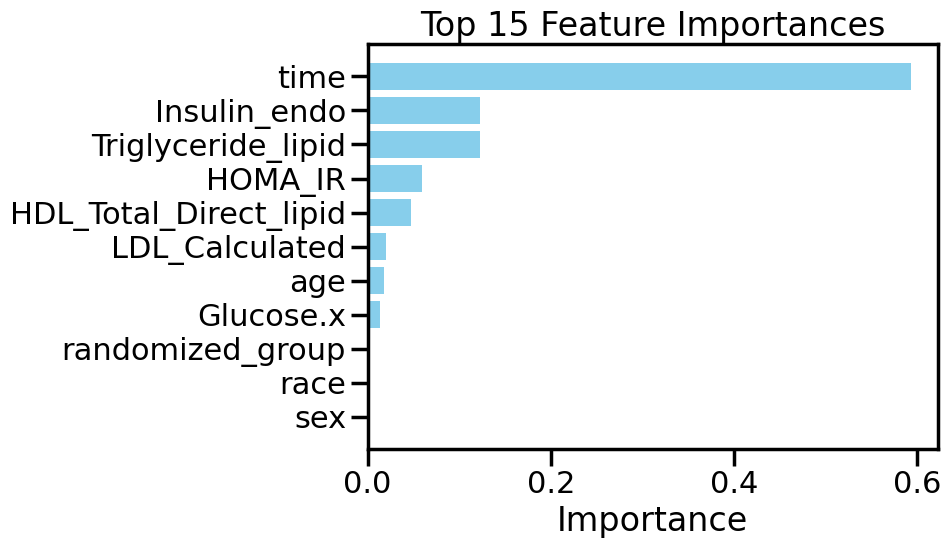

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:811: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
INFO     [merf.py:307] Training GLL is 144.3990020220363 at iteration 1.
INFO     [merf.py:307] Training GLL is 146.7893197287793 at iteration 2.
INFO     [merf.py:307] Training GLL is 149.30219717636862 at iteration 3.


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 147.72566200727928 at iteration 4.
INFO     [merf.py:307] Training GLL is 145.80367848168677 at iteration 5.
INFO     [merf.py:307] Training GLL is 150.0194533276052 at iteration 6.
INFO     [merf.py:307] Training GLL is 141.27856444512219 at iteration 7.
INFO     [merf.py:307] Training GLL is 142.76575406286364 at iteration 8.
INFO     [merf.py:307] Training GLL is 141.3474957988136 at iteration 9.
INFO     [merf.py:307] Training GLL is 142.1670061391935 at iteration 10.


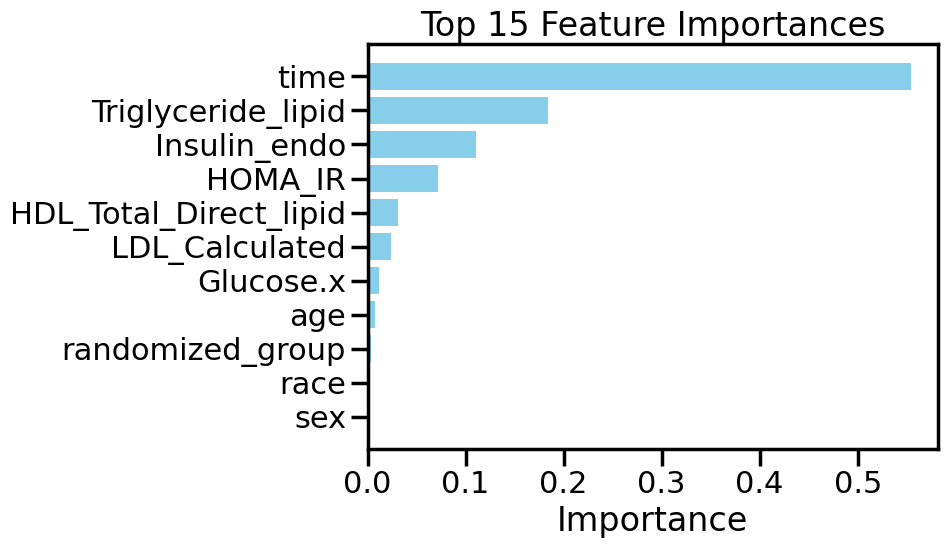

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 33.59330257686963 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.62903072408184 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 36.389000718965484 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 43.66319688140143 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.11717102325034 at iteration 7.
INFO     [merf.py:307] Training GLL is 52.18444365735921 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

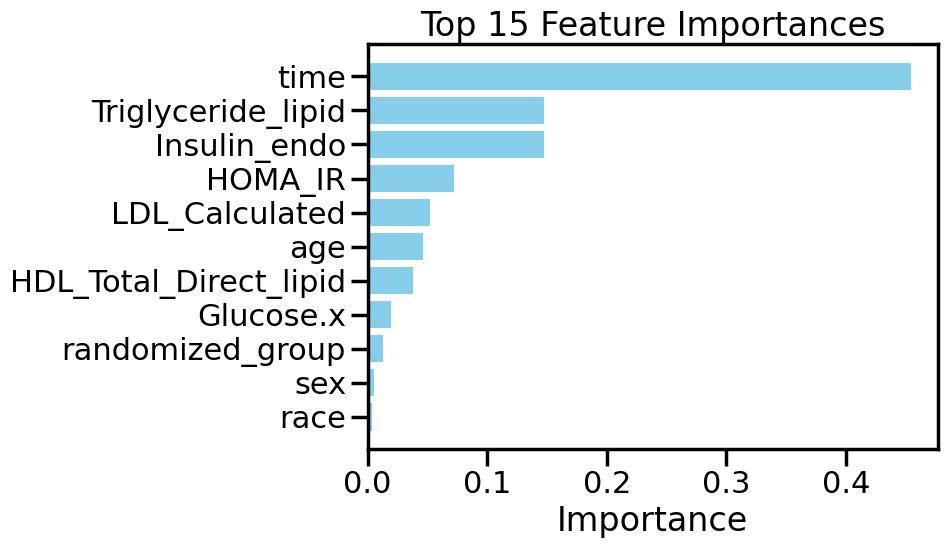

INFO     [merf.py:307] Training GLL is 141.25359059988264 at iteration 1.
INFO     [merf.py:307] Training GLL is 148.2121649403095 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


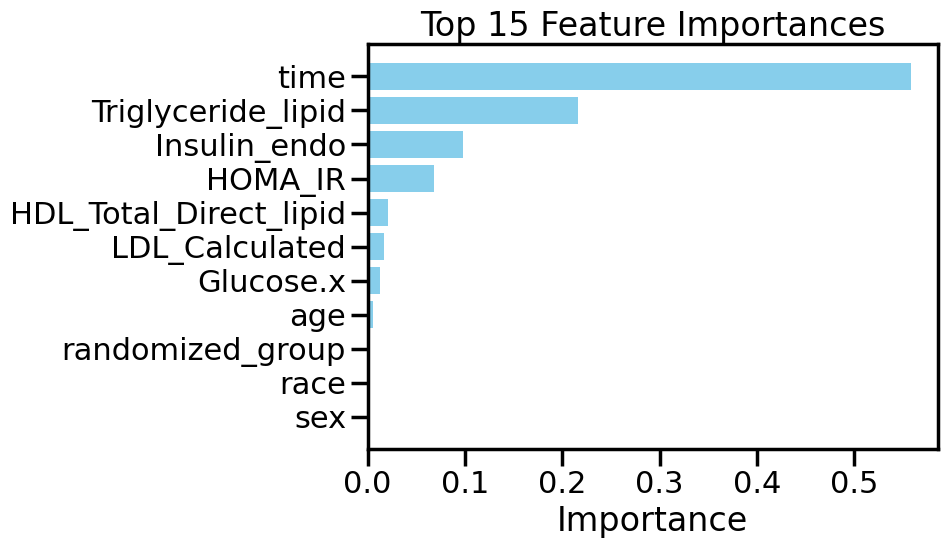

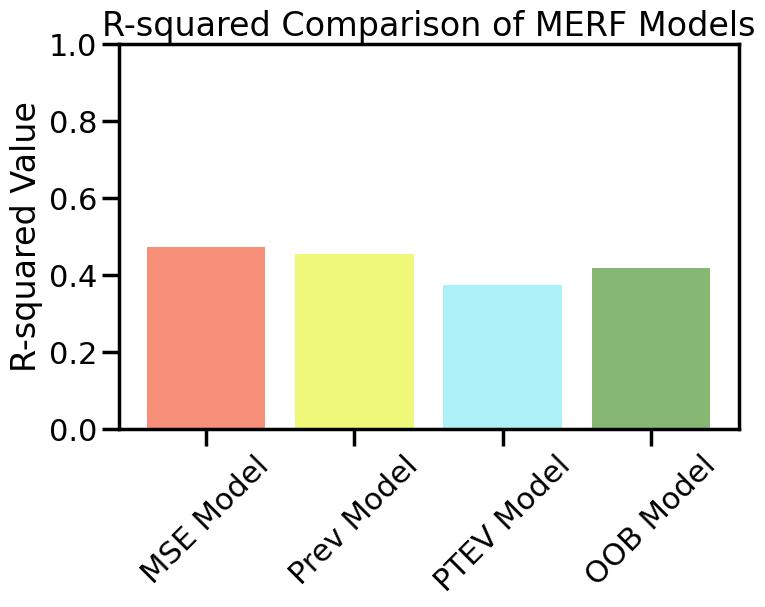

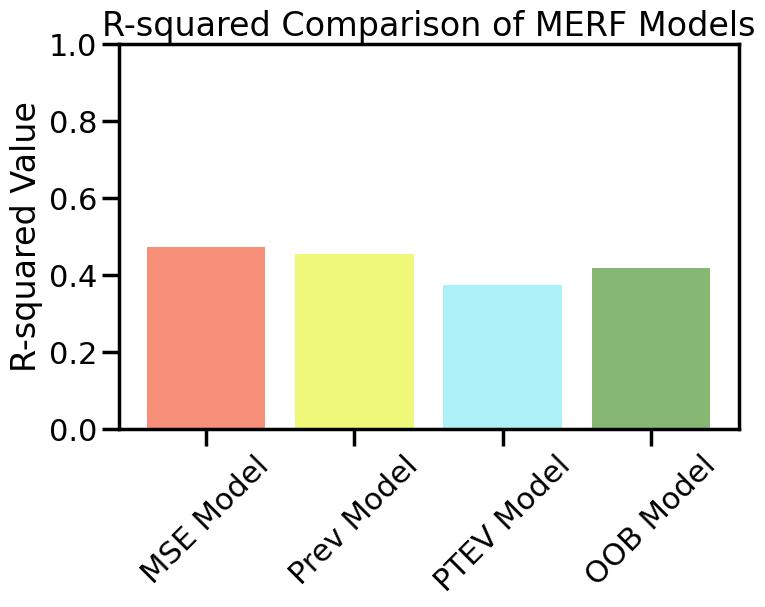

Best model: MSE Model with R-squared: 0.4729
R-squared values: {'MSE Model': 0.47294364782102316, 'Prev Model': 0.45442638222685083, 'PTEV Model': 0.37528606446562285, 'OOB Model': 0.4179031549125559}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  -2.468752   0.472944   
1    MSE Model  -1.819697   0.472944   
2    MSE Model  -3.964457   0.472944   
3    MSE Model  -3.035950   0.472944   
4    MSE Model  -3.210267   0.472944   
..         ...        ...        ...   
207  OOB Model   1.023651   0.417903   
208  OOB Model   0.018622   0.417903   
209  OOB Model   0.188133   0.417903   
210  OOB Model   0.337227   0.417903   
211  OOB Model   0.225896   0.417903   

                            Top_15_Feature_Importances  Cluster  Time  
0    [{'Feature': 'time', 'Importance': 0.593043231...  AGA-071   6.0  
1    [{'Feature': 'time', 'Importance': 0.593043231...  AHE-055   6.0  
2    [{'Feature': 'time', 'Importance': 0.593043231...  ALO-163   6.0  
3    [{'Fe

In [16]:
column_sets = {
    #"basic": basic,
    "meta_keep": meta_keep,
    #"only_grs": only_grs, 
    #"only_taxa": only_taxa,
    #"only_micom": only_micom,
    #"only_pathway": only_pathway
    #"only_metabo" : only_metabo
    #"only_all" : all_col
}
# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = delta[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/finetuning_csvs/{key}_delta_april29.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/final_merf_plots/"
    r2_out =  f"{key}_delta_r2_april29.pdf"
    r2_adj_out = f"{key}_delta_r2_adj_april29.pdf"
    feature_imp_out = f"{key}_delta_ft_imp_april29.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/final_merf_dfs/{key}_delta_april29.csv"

# Create train and test sets for the current subset
train_set = DATA[DATA[ID_VAR].isin(train_names)]  # Select rows where ID_VAR is in train_names
test_set = DATA[DATA[ID_VAR].isin(test_names)]    # Select rows where ID_VAR is in test_names

# Ensure clusters_train and clusters_test are pandas Series
clusters_train = pd.Series(train_set[ID_VAR])  # Convert to pandas Series
clusters_test = pd.Series(test_set[ID_VAR])    # Convert to pandas Series

# Proceed with MERF analysis for the current subset
print("---------- Select predictors for training set ----------")
X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
Y = train_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
Z = np.ones((train_set.shape[0], 1))  # Create random effects matrix with ones

# Check lengths before fitting
print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
assert len(X) == len(clusters_train), "Length of X does not match length of clusters_train"
assert len(X) == len(Y), "Length of X does not match length of Y"
print("Final columns after drop:", X.columns.to_list())
print("X train values:", train_set[BMI_VAR])

print("---------- Select predictors for test set ----------")
X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
Y_new = test_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set[ID_VAR])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))  # Create random effects matrix with ones
time_new = test_set[TIME_VAR].astype(float).to_numpy()  # Convert time values to numeric arrayo numeric array

# Hyperparameters to tune
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None],
    'min_samples_split': [0.05, 0.1, 0.15],
    'max_iter': [2, 10],
    'n_splits': [3, 5, 10] #cross-validation
}
# Create training features
# X = train_set.drop(columns=columns_to_drop, errors='ignore')
y = train_set[[BMI_VAR]]
y = y[BMI_VAR].to_numpy() # Convert Y to numeric array
clusters = train_set[ID_VAR].to_numpy() # Get ID variables
z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

best_score = float('inf')
best_params = {}
results = []  # Initialize a list to store the results of each iteration

# Loop through all possible combinations of parameters
total_combinations = len(list(itertools.product(*param_grid.values())))  # Calculate total combinations
for idx, params in enumerate(itertools.product(*param_grid.values())):
    n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
    
    # Print progress
    progress_percentage = (idx + 1) / total_combinations * 100
    print(f"Combination: {params}\n")
    print(f"Progress: {progress_percentage:.2f}% completed\n")
    scores, prev, ptev, oob_scores = [], [], [], []  # Initialize lists for scores

    # K-fold cross-validation with variable n_splits
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X):
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
        y_train, y_test = y[train_index], y[test_index]
        clusters_train, clusters_test = clusters[train_index], pd.Series(clusters[test_index])
        z_train, z_test = z[train_index], z[test_index]

        print("Length of clusters_train:", len(clusters_train))
        print("Length of clusters_test:", len(clusters_test))
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)

        model = MERF(
                # Specify the fixed effects model as a Random Forest Regressor
            fixed_effects_model=RandomForestRegressor(
                n_estimators=n_estimators,  # Number of trees in the forest
                max_depth=max_depth,  # Maximum depth of each tree
                min_samples_split=min_samples_split,  # Minimum samples required to split an internal node
                n_jobs=1,  # Number of jobs to run in parallel
                oob_score=True  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                ),
                # Generalized Linear Model (GLM) early stopping threshold
            gll_early_stop_threshold=None,  # No early stopping threshold set
                # Maximum number of iterations for the MERF algorithm
            max_iterations=max_iter  # Maximum number of iterations to run the MERF algorithm
            )
        model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train), y_train)
        y_pred = model.predict(X_test, z_test, clusters_test)
        scores.append(np.mean((y_pred - y_test) ** 2)) # MSE
        
        # Calculate ptev and prev
        total_variance = np.var(y_test)
        random_effect_variance = np.var(y_test - y_pred)
        fixed_effect_variance = total_variance - random_effect_variance

        ptev.append(np.mean(fixed_effect_variance / total_variance if total_variance > 0 else 0))
        prev.append(np.mean(random_effect_variance / total_variance if total_variance > 0 else 0))

        # Calculate OOB score
        forest = model.trained_fe_model
        oob_score = round(forest.oob_score_ * 100, 1)  # percent variation
        oob_scores.append(oob_score)

        # Print ptev, prev, and OOB score for the current iteration
        print(f"Combination, ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

    # Calculate the mean of the scores for the current combination of parameters
    mean_score = np.mean(scores)
    if mean_score < best_score:
        best_score = mean_score
        best_params = params

    # Append the results of the current iteration to the results list
    result_dict = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'max_iter': max_iter,
        'n_splits': n_splits,
        'mean_mse_score': mean_score,
        'mean_prev': np.mean(prev),
        'mean_ptev': np.mean(ptev),
        'oob_score': np.mean(oob_scores)
    }
    results.append(result_dict)

print("Best parameters:", best_params)
print("Best score:", best_score)

# Convert the results list to a DataFrame and save it to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(OUT, index=False)

print("---------- Run MERF models ----------")
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters,
    X_new, Y_new, Z_new, clusters_new,
    results_df,
    output_dir, r2_out, r2_adj_out, 
    feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)
print("---------- Done saving Merf output ----------")